# **TEXT MINING**

## **Practice: Text analytics for a dataset of biomedical documents**

### Fecha: **24/05/2022**

### Autor: **Víctor Manuel López Molina**

**The practice consists of building a model for the automatic classification of texts in the following
five categories**:
- Alzheimer
- Bladder cancer
- Breast Cancer
- Cervical Cancer
- Negative

The dataset was provided in class.
**Two different models will be developed and tested:**

**PART 1: "shallow" model**.

The idea is:
- Clean and preprocess the text as much as possible, make everything lowercase, manage
numbers, remove stop words, remove section names such as “background” etc. using
regular expressions.
- Vectorize the documents. You can use one of the following techniques:
  - tf-idf
  - tf-idf + dimensionality reduction such as LSA / PCA
- Build a classifier testing different algorithms and configurations (for example decision trees,
random forest, logistic regression, one-layer neural networks etc.) trying to optimize the model
in terms of its accuracy
- Build a clustering model optimizing the separation between the different clusters.

**The practice can be delivered in one of the following two formats:**

- Notebook with code + pdf with results memory.
- Notebook where the results are summarized and explained in "markdown" cells contained in the
notebook.

**What should the results summary contain? (in both delivery formats):**
- Summary of cleaning techniques, preprocessing, vocabulary construction used, tested
parameter values, and results obtained
- Summary of embedding techniques used, tested midwifery values (for example number of
dimensions), and results obtained
- Summary of tested models, values of parameters studied (for example in a neural network type
of layers, number of neurons, regularization midwives, etc.) and quality indicators of the model.
To measure the quality of the model, the score (hit rate) and the confusion matrix will be used.
The degree of overfitting of the model (level of degradation of test scores with respect to
training) will also be analyzed.

In the results section, it is expected that there will be at least one results table for each of the three
previous sections.

As a guide, if it is decided to deliver the work in notebook + pdf format with results memory, the
expected length of the memory will be around 15-20 pages (including graphs, tables, results and
explanation of results).

Finally, it is important that the results are explained and reasoned in memory (if the score with one
configuration is worse than with another, reason an explanation).

# **1. "SHALLOW MODEL"**

## **1.1: Importación de los paquetes y *datasets* necesarios**

In [ ]:
COLAB = True

In [ ]:
if COLAB:
    %tensorflow_version 1.x

In [ ]:
#Importación de los paquetes:

import pandas as pd
import numpy as np
from glob import glob
import warnings
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import make_scorer,balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
pd.options.display.max_colwidth = 100

In [ ]:
# Importación de los datasets:

if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    ficheros = [('1Z5MlJaUPmWQdvKDK474VVAnsXBgDWWAp', './Alzheimer_abstracts.tsv'),
                ('11BAN4eMl7ZNwM3jTo_6RAwP7JSbU6Jj7', './Bladder_Cancer_abstracts.tsv'),
                ('1symeSwQfX9NAESQUPMVwbOMZEkHMA4DD', './Breast_Cancer_abstracts.tsv'),
                ('1blBKcPMG3v10Nelvzyi4qGYGsCaLE9SQ', './Cervical_Cancer_abstracts.tsv'),
                ('120o0IhcGhvIc36jk8GKQLlVOEogUxHnx', './negative_abstracts.tsv')]
    for f in ficheros:
      gdd.download_file_from_google_drive(file_id=f[0], dest_path=f[1], overwrite=True, showsize=True)

1.5 MiB Done.
1.5 MiB Done.
1.6 MiB Done.
1.6 MiB Done.
1.5 MiB Done.


In [ ]:
!ls #Tras importar los datos, comprobamos que están listos para ser utilizados.

Alzheimer_abstracts.tsv       Cervical_Cancer_abstracts.tsv
Bladder_Cancer_abstracts.tsv  negative_abstracts.tsv
Breast_Cancer_abstracts.tsv   sample_data


## **1.2: Procesado de los *datasets***

Tras haber importado los paquetes necesarios, vamos a disponer la información contenida en cada uno de los *datasets* cargados en una única tabla, en donde encontraremos todas las entradas de todos los *datasets* correspondiéndose cada entrada con una fila en dicha tabla final. Además, las columnas de la tabla serán un id de la entrada o artículo bibliográfico, el título del mismo, el *abstract* del mismo, el texto del mismo y el tipo o clase en el que se clasifica dicho artículo (por ejemplo, *bladder cancer* o *alzheimer*).

En primer lugar, vamos a generar dos listas, llamadas *dfs* y *file_names*, en donde se recojan el contenido de los *datasets* y sus nombres.

In [ ]:
dfs = []
file_names = []
for fichero in glob("./*.tsv"):
    df = pd.read_csv(fichero, sep="\t", header=None)
    df.columns = ["id", "title", "abstract"]
    dfs.append(df)
    file_names.append(fichero.split("/")[-1])

A continuación se muestra el nombre de los *datasets*, englobados en la variable *file_names*:

In [ ]:
file_names

['Breast_Cancer_abstracts.tsv',
 'Bladder_Cancer_abstracts.tsv',
 'Alzheimer_abstracts.tsv',
 'Cervical_Cancer_abstracts.tsv',
 'negative_abstracts.tsv']

A continuación se muestra el contenido de los *datasets*, recogido en la variable *dfs*. Esta variable es una lista en donde cada elemento es el contenido de cada *dataset* cargado. Por ejemplo, *dfs[0]* se corresponde con el contenido del *dataset* relativo al Alzheimer, algo que se muestra a continuación:

In [ ]:
dfs

[           id  \
 0    28424130   
 1    28423035   
 2    28422972   
 3    28420378   
 4    28420351   
 ..        ...   
 995  27848916   
 996  27847817   
 997  27847402   
 998  27847287   
 999  27847208   
 
                                                                                                    title  \
 0    Invasive Pleomorphic Lobular Histology Is an Adverse Prognostic Factor on Survival in Patients w...   
 1               Genetic profiling of putative breast cancer stem cells from malignant pleural effusions.   
 2    Challenges in enumeration of CTCs in breast cancer using techniques independent of cytokeratin e...   
 3    A cross-sectional survey assessing factors associated with reading cancer screening information:...   
 4    Prognostic significance of TRAIL-R3 and CCR-2 expression in tumor epithelial cells of patients w...   
 ..                                                                                                   ...   
 995               

In [ ]:
dfs[0].head()

id  \
0  28424130   
1  28423035   
2  28422972   
3  28420378   
4  28420351   

                                                                                                 title  \
0  Invasive Pleomorphic Lobular Histology Is an Adverse Prognostic Factor on Survival in Patients w...   
1             Genetic profiling of putative breast cancer stem cells from malignant pleural effusions.   
2  Challenges in enumeration of CTCs in breast cancer using techniques independent of cytokeratin e...   
3  A cross-sectional survey assessing factors associated with reading cancer screening information:...   
4  Prognostic significance of TRAIL-R3 and CCR-2 expression in tumor epithelial cells of patients w...   

                                                                                              abstract  
0  Invasive pleomorphic lobular carcinoma (IPLC) is defined to be an uncommon and different subtype...  
1  A common symptom during late stage breast cancer disease is pleural effusion, which is related t...  
2  INTRODUCTION: Given the current postulated plasticity between epithelial and mesenchymal states ...  
3  BACKGROUND: There is broad agreement that cancer screening invitees should know the risks and be...  
4  BACKGROUND: Tumor epithelial cells (TEpCs) and spindle-shaped stromal cells, not associated with...

Ahora, vamos a tomar los nombres de los archivos y extraer los nombres de las patologías a partir de los mismos, guardándolos en la variable *type_names*:

In [ ]:
type_names = [x.replace("_abstracts.tsv", "")
              for x in file_names]
type_names

['Breast_Cancer', 'Bladder_Cancer', 'Alzheimer', 'Cervical_Cancer', 'negative']

Finalmente, en base a esta información extraída, vamos a generar la tabla final con la cual trabajaremos en esta práctica, en donde se recoge el contenido de todos los *datasets*, indicándose, para cada entrada o estudio de la tabla (es decir, para cada fila), la enfermedad con la que está asociado.

In [ ]:
ids       = []
titles    = []
abstracts = []
types     = []
for df,name in zip(dfs,type_names):
    ids.extend(list(df["id"]))
    titles.extend(list(df["title"]))
    abstracts.extend(list(df["abstract"]))
    types.extend(len(df)*[name])
len(abstracts), len(types) #Vemos que, si bien cada dataset tenía 1000 entradas, al combinarlas, ahora tenemos 5000 entradas en la tabla final.

(5000, 5000)

Esta es la tabla final con la que trabajaremos en esta práctica:

In [ ]:
data = pd.DataFrame({
    "id":ids,
    "title":titles,
    "abstract":abstracts,
    "text":abstracts,
    "type":types
})
data

id  \
0     28424130   
1     28423035   
2     28422972   
3     28420378   
4     28420351   
...        ...   
4995  27182736   
4996  26925253   
4997  27171471   
4998  26986421   
4999  28018388   

                                                                                                    title  \
0     Invasive Pleomorphic Lobular Histology Is an Adverse Prognostic Factor on Survival in Patients w...   
1                Genetic profiling of putative breast cancer stem cells from malignant pleural effusions.   
2     Challenges in enumeration of CTCs in breast cancer using techniques independent of cytokeratin e...   
3     A cross-sectional survey assessing factors associated with reading cancer screening information:...   
4     Prognostic significance of TRAIL-R3 and CCR-2 expression in tumor epithelial cells of patients w...   
...                                                                                                   ...   
4995  Universal Coverage without Universal Access: Institutional Barriers to Health Care among Women S...   
4996  Decreased use of glucocorticoids in biological-experienced patients with rheumatoid arthritis wh...   
4997  Evaluating the Utility of Single-Locus DNA Barcoding for the Identification of Ribbon Worms (Phy...   
4998  Convection-driven kinematic dynamos at low Rossby and magnetic Prandtl numbers: Single mode solu...   
4999  Coronatine Inhibits Stomatal Closure through Guard Cell-Specific Inhibition of NADPH Oxidase-Dep...   

                                                                                                 abstract  \
0     Invasive pleomorphic lobular carcinoma (IPLC) is defined to be an uncommon and different subtype...   
1     A common symptom during late stage breast cancer disease is pleural effusion, which is related t...   
2     INTRODUCTION: Given the current postulated plasticity between epithelial and mesenchymal states ...   
3     BACKGROUND: There is broad agreement that cancer screening invitees should know the risks and be...   
4     BACKGROUND: Tumor epithelial cells (TEpCs) and spindle-shaped stromal cells, not associated with...   
...                                                                                                   ...   
4995  BACKGROUND: Access to health care is a crucial determinant of health. Yet, even within settings ...   
4996  INTRODUCTION: Prolonged glucocorticoid use may increase the risk of adverse safety outcomes, inc...   
4997  Whereas many nemerteans (ribbon worms; phylum Nemertea) can be identified from external characte...   
4998  The onset of dynamo action is investigated within the context of a newly developed low Rossby, l...   
4999  Microbes trigger stomatal closure through microbe-associated molecular patterns (MAMPs). The bac...   

                                                                                                     text  \
0     Invasive pleomorphic lobular carcinoma (IPLC) is defined to be an uncommon and different subtype...   
1     A common symptom during late stage breast cancer disease is pleural effusion, which is related t...   
2     INTRODUCTION: Given the current postulated plasticity between epithelial and mesenchymal states ...   
3     BACKGROUND: There is broad agreement that cancer screening invitees should know the risks and be...   
4     BACKGROUND: Tumor epithelial cells (TEpCs) and spindle-shaped stromal cells, not associated with...   
...                                                                                                   ...   
4995  BACKGROUND: Access to health care is a crucial determinant of health. Yet, even within settings ...   
4996  INTRODUCTION: Prolonged glucocorticoid use may increase the risk of adverse safety outcomes, inc...   
4997  Whereas many nemerteans (ribbon worms; phylum Nemertea) can be identified from external characte...   
4998  The onset of dynamo action is investigated within the context of a newly develope

En la siguiente celda, se demuestra que tenemos 1000 entradas o estudios asociados a cada patología o *dataset*, combinadas todas en la tabla *data*.

In [ ]:
data["type"].value_counts()

Breast_Cancer      1000
Bladder_Cancer     1000
Alzheimer          1000
Cervical_Cancer    1000
negative           1000
Name: type, dtype: int64

## **1.3: Pre-procesado de los *datasets***

### **1.3.1: Instalación e importación de los paquetes necesarios**

Puesto que, cada vez que se inicia el entorno de ejecución, es necesario instalar los paquetes necesarios de *nltk* para el pre-procesado de los textos, vamos a instalarlos y cargarlos para poder llevar a cabo los pasos sucesivos de este apartado:

In [ ]:
import nltk
from string import punctuation
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### **1.3.2: Reordenación alfabética de los textos**

In [ ]:
data = data.sort_values("text").reset_index(drop=True)
data

id  \
0     27816982   
1     27092587   
2     27486640   
3     27382284   
4     27354798   
...        ...   
4995  28000900   
4996  26919225   
4997  27199504   
4998  27222134   
4999  27377093   

                                                                                                    title  \
0                            Cytology at the Time of HPV: Some Things to Think about when Discussing HPV.   
1     Production of precursors for anti-Alzheimer drugs: Asymmetric bioreduction in a packed-bed biore...   
2                                   Empagliflozin (Jardiance). Type 2 diabetes: no rush to use this drug.   
3     A stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...   
4     Elimination of the biphasic pharmacodynamics of 15d-PGJ2 by controlling its release from a nanoe...   
...                                                                                                   ...   
4995  miR-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...   
4996  The role of urinary pH in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...   
4997  Prognostic and Clinicopathological Significance of Downregulated p16 Expression in Patients with...   
4998                           P21 and p27 Immunoexpression in Upper Urinary Tract Urothelial Carcinomas.   
4999                                      Lymphoepithelioma-like carcinoma of the bladder: A case report.   

                                                                                                 abstract  \
0     'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...   
1     (S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...   
2     * In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...   
3     10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...   
4     15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...   
...                                                                                                   ...   
4995  microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...   
4996  o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...   
4997  p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...   
4998  p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...   
4999  type of low differentiated carcinoma of the nasopharyngeal region characterized by marked infilt...   

                                                                                                     text  \
0     'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...   
1     (S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...   
2     * In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...   
3     10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...   
4     15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...   
...                                                                                                   ...   
4995  microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...   
4996  o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...   
4997  p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...   
4998  p21 and p27 are members of cyclin-dependent kinase family, which function as tumo

### **1.3.3: Eliminación de espaciados adicionales**

Puesto que, tras obtener la tabla sobre la cual trabajar, algunas entradas tenían espaciados repetidos, éstos se han eliminado con el siguiente comando, de forma que los espaciados fuesen en todos los casos de un único espacio:

In [ ]:
data_no_additional_spaces=data.replace(" +"," ") #Sustituir múltiples espacios por uno solo
data_no_additional_spaces

id  \
0     27816982   
1     27092587   
2     27486640   
3     27382284   
4     27354798   
...        ...   
4995  28000900   
4996  26919225   
4997  27199504   
4998  27222134   
4999  27377093   

                                                                                                    title  \
0                            Cytology at the Time of HPV: Some Things to Think about when Discussing HPV.   
1     Production of precursors for anti-Alzheimer drugs: Asymmetric bioreduction in a packed-bed biore...   
2                                   Empagliflozin (Jardiance). Type 2 diabetes: no rush to use this drug.   
3     A stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...   
4     Elimination of the biphasic pharmacodynamics of 15d-PGJ2 by controlling its release from a nanoe...   
...                                                                                                   ...   
4995  miR-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...   
4996  The role of urinary pH in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...   
4997  Prognostic and Clinicopathological Significance of Downregulated p16 Expression in Patients with...   
4998                           P21 and p27 Immunoexpression in Upper Urinary Tract Urothelial Carcinomas.   
4999                                      Lymphoepithelioma-like carcinoma of the bladder: A case report.   

                                                                                                 abstract  \
0     'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...   
1     (S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...   
2     * In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...   
3     10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...   
4     15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...   
...                                                                                                   ...   
4995  microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...   
4996  o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...   
4997  p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...   
4998  p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...   
4999  type of low differentiated carcinoma of the nasopharyngeal region characterized by marked infilt...   

                                                                                                     text  \
0     'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...   
1     (S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...   
2     * In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...   
3     10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...   
4     15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...   
...                                                                                                   ...   
4995  microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...   
4996  o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...   
4997  p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...   
4998  p21 and p27 are members of cyclin-dependent kinase family, which function as tumo

### **1.3.4: Eliminación de las cabeceras (*BACKGROUND*, *CONCLUSIONS*, etc)**

Tras esto, además, puesto que para los *abstracts* de los estudios existen secciones como *BACKGROUND*, *CONCLUSIONS*, *METHODS*, etc., estos también se han eliminado, por medio de la siguiente expresión regular:

In [ ]:
data_processed=data_no_additional_spaces.replace("([A-Z]+: |[A-Z]+ ([A-Z]+)*: )","",regex=True) #Eliminar los section names
data_processed

id  \
0     27816982   
1     27092587   
2     27486640   
3     27382284   
4     27354798   
...        ...   
4995  28000900   
4996  26919225   
4997  27199504   
4998  27222134   
4999  27377093   

                                                                                                    title  \
0                                 Cytology at the Time of Some Things to Think about when Discussing HPV.   
1     Production of precursors for anti-Alzheimer drugs: Asymmetric bioreduction in a packed-bed biore...   
2                                   Empagliflozin (Jardiance). Type 2 diabetes: no rush to use this drug.   
3     A stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...   
4     Elimination of the biphasic pharmacodynamics of 15d-PGJ2 by controlling its release from a nanoe...   
...                                                                                                   ...   
4995  miR-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...   
4996  The role of urinary pH in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...   
4997  Prognostic and Clinicopathological Significance of Downregulated p16 Expression in Patients with...   
4998                           P21 and p27 Immunoexpression in Upper Urinary Tract Urothelial Carcinomas.   
4999                                      Lymphoepithelioma-like carcinoma of the bladder: A case report.   

                                                                                                 abstract  \
0     'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...   
1     (S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...   
2     * In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...   
3     10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...   
4     15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...   
...                                                                                                   ...   
4995  microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...   
4996  o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...   
4997  p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...   
4998  p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...   
4999  type of low differentiated carcinoma of the nasopharyngeal region characterized by marked infilt...   

                                                                                                     text  \
0     'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...   
1     (S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...   
2     * In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...   
3     10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...   
4     15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...   
...                                                                                                   ...   
4995  microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...   
4996  o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...   
4997  p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...   
4998  p21 and p27 are members of cyclin-dependent kinase family, which function as tumo

### **1.3.5: Transformación de los datos para que estén en minúscula**

A continuación, con las cabeceras ya eliminadas de la tabla, vamos a volver todo el contenido de la misma en minúscula, para así poder aplicar los pasos sucesivos:

In [ ]:
data_lower=data_processed.applymap(lambda x: x.lower() if type(x) == str else x) #Todo minúscula
data_lower

id  \
0     27816982   
1     27092587   
2     27486640   
3     27382284   
4     27354798   
...        ...   
4995  28000900   
4996  26919225   
4997  27199504   
4998  27222134   
4999  27377093   

                                                                                                    title  \
0                                 cytology at the time of some things to think about when discussing hpv.   
1     production of precursors for anti-alzheimer drugs: asymmetric bioreduction in a packed-bed biore...   
2                                   empagliflozin (jardiance). type 2 diabetes: no rush to use this drug.   
3     a stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...   
4     elimination of the biphasic pharmacodynamics of 15d-pgj2 by controlling its release from a nanoe...   
...                                                                                                   ...   
4995  mir-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...   
4996  the role of urinary ph in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...   
4997  prognostic and clinicopathological significance of downregulated p16 expression in patients with...   
4998                           p21 and p27 immunoexpression in upper urinary tract urothelial carcinomas.   
4999                                      lymphoepithelioma-like carcinoma of the bladder: a case report.   

                                                                                                 abstract  \
0     'in the current 28 member states of the european union (eu), approximately 34,000 new cases of c...   
1     (s)-1-phenylethanol derivatives, which are the precursors of many pharmacological products, have...   
2     * in early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...   
3     10-hydroxycamptothecin (10-hcpt) is a promising anticancer drug with a wide spectrum of antitumo...   
4     15-deoxy-delta12,14-prostaglandin j2 (15d-pgj2) has a dual action of stimulating anti-inflammati...   
...                                                                                                   ...   
4995  micrornas (mirnas), a class of small non-coding rna molecules, can regulate gene expression by i...   
4996  o-phenylphenol (opp) is a widely used fungicide and antibacterial agent that at high doses has b...   
4997  p16, encoded by the cdkn2a gene, is a tumor suppressor that has been widely studied in cancer re...   
4998  p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...   
4999  type of low differentiated carcinoma of the nasopharyngeal region characterized by marked infilt...   

                                                                                                     text  \
0     'in the current 28 member states of the european union (eu), approximately 34,000 new cases of c...   
1     (s)-1-phenylethanol derivatives, which are the precursors of many pharmacological products, have...   
2     * in early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...   
3     10-hydroxycamptothecin (10-hcpt) is a promising anticancer drug with a wide spectrum of antitumo...   
4     15-deoxy-delta12,14-prostaglandin j2 (15d-pgj2) has a dual action of stimulating anti-inflammati...   
...                                                                                                   ...   
4995  micrornas (mirnas), a class of small non-coding rna molecules, can regulate gene expression by i...   
4996  o-phenylphenol (opp) is a widely used fungicide and antibacterial agent that at high doses has b...   
4997  p16, encoded by the cdkn2a gene, is a tumor suppressor that has been widely studied in cancer re...   
4998  p21 and p27 are members of cyclin-dependent kinase family, which function as tumo

### **1.3.6: Tokenización de los textos**

Tras esto, y antes de eliminar los *stopwords*, vamos a tokenizar todos los *abstracts* de la tabla, esto es, transformar las frases en unidades más pequeñas llamadas ***tokens***, en este caso palabras:

In [ ]:
tokenized_text=data_lower["text"].apply(lambda x: word_tokenize(x)) #Tokenizamos los textos.
tokenized_text

0       ['in, the, current, 28, member, states, of, the, european, union, (, eu, ), ,, approximately, 34...
1       [(, s, ), -1-phenylethanol, derivatives, ,, which, are, the, precursors, of, many, pharmacologic...
2       [*, in, early, 2016, ,, metformin, monotherapy, remains, the, treatment, of, choice, for, most, ...
3       [10-hydroxycamptothecin, (, 10-hcpt, ), is, a, promising, anticancer, drug, with, a, wide, spect...
4       [15-deoxy-delta12,14-prostaglandin, j2, (, 15d-pgj2, ), has, a, dual, action, of, stimulating, a...
                                                       ...                                                 
4995    [micrornas, (, mirnas, ), ,, a, class, of, small, non-coding, rna, molecules, ,, can, regulate, ...
4996    [o-phenylphenol, (, opp, ), is, a, widely, used, fungicide, and, antibacterial, agent, that, at,...
4997    [p16, ,, encoded, by, the, cdkn2a, gene, ,, is, a, tumor, suppressor, that, has, been, widely, s...
4998    [p21, and, p27, are,

### **1.3.7: Definición de los *stopwords***

A continuación, antes de borrar los *stopwords* de la tabla, debemos definirlos en una variable. Recordemos que los *stopwords* son palabras que no aportan ningún significado al texto, como ocurre con las preposiciones, artículos o conjunciones, y que son muy frecuentes en el mismo. Por tanto, la eliminación de los *stopwords* permite prestar más atención a las palabras que realmente importan en un texto. En este caso, como los *datasets* que estamos manejando en esta práctica se encuentran en lengua inglesa, los *stopwords* que usaremos serán los del inglés, para así poder eliminarlos de los *abstracts*. Además, como podemos apreciar en la celda inferior, aparte de los *stopwords*, vamos a eliminar también los signos de puntuación:

In [ ]:
mystopwords = stopwords.words("english")
mystopwords.extend(punctuation) #Definimos los stopwords.
mystopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### **1.3.8: Eliminación de los *stopwords* y los signos de puntuación**

A continuación, vamos a eliminar los *stopwords* y los signos de puntuación de los *abstracts* tokenizados.

In [ ]:
removed_stopwords=tokenized_text.apply(lambda x: ' '.join([word for word in x if word not in (mystopwords)])) #Eliminamos los stopwords y los signos de puntuación.
removed_stopwords

0       'in current 28 member states european union eu approximately 34,000 new cases cervical cancer 13...
1       -1-phenylethanol derivatives precursors many pharmacological products also used anti-alzheimer d...
2       early 2016 metformin monotherapy remains treatment choice patients type 2 diabetes several alter...
3       10-hydroxycamptothecin 10-hcpt promising anticancer drug wide spectrum antitumor activities due ...
4       15-deoxy-delta12,14-prostaglandin j2 15d-pgj2 dual action stimulating anti-inflammation anti-pro...
                                                       ...                                                 
4995    micrornas mirnas class small non-coding rna molecules regulate gene expression interacting 3'-un...
4996    o-phenylphenol opp widely used fungicide antibacterial agent high doses shown cause bladder canc...
4997    p16 encoded cdkn2a gene tumor suppressor widely studied cancer research however relationship p16...
4998    p21 p27 members cycl

### **1.3.9: Tokenización de los textos pre-procesados**

A continuación, vamos a tokenizar de nuevo los *abstracts* de la tabla de estudios con el fin de ejecutar *lemmatizer* posteriormente:

In [ ]:
tokenized_text_no_stopwords=removed_stopwords.apply(lambda x: word_tokenize(x)) #Tokenizamos los textos.
tokenized_text_no_stopwords

0       ['in, current, 28, member, states, european, union, eu, approximately, 34,000, new, cases, cervi...
1       [-1-phenylethanol, derivatives, precursors, many, pharmacological, products, also, used, anti-al...
2       [early, 2016, metformin, monotherapy, remains, treatment, choice, patients, type, 2, diabetes, s...
3       [10-hydroxycamptothecin, 10-hcpt, promising, anticancer, drug, wide, spectrum, antitumor, activi...
4       [15-deoxy-delta12,14-prostaglandin, j2, 15d-pgj2, dual, action, stimulating, anti-inflammation, ...
                                                       ...                                                 
4995    [micrornas, mirnas, class, small, non-coding, rna, molecules, regulate, gene, expression, intera...
4996    [o-phenylphenol, opp, widely, used, fungicide, antibacterial, agent, high, doses, shown, cause, ...
4997    [p16, encoded, cdkn2a, gene, tumor, suppressor, widely, studied, cancer, research, however, rela...
4998    [p21, p27, members, 

### **1.3.10: Ejecución de *lemmatizer***

Finalmente, vamos a ejecutar ***lemmatizer*** sobre los *abstracts* tokenizados. Esta herramienta, como vimos en clase, toma diversos diccionarios y transforma los *tokens* (en este caso, palabras) para que sean más generales pero sin perder el significado, tal y como se muestra en los siguientes ejemplos:

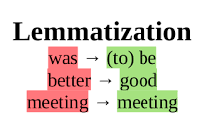

Básicamente, *lemmatizer* considera el análisis morfológico de las palabras, de ahí que el algoritmo necesite tener a disposición varios diccionarios para transformar las palabras en sus *lemmas*, es decir, sus raíces o base común. Dicho esto, vamos ejecutar esta herramienta para nuestros *abstracts*:

In [ ]:
lemmatizer=WordNetLemmatizer()
lemmatized_text=tokenized_text_no_stopwords.apply(lambda x: [lemmatizer.lemmatize(word) for word in x]) #ejecutamos lemmatize
final_text=lemmatized_text.apply(lambda x: " ".join(x)) #fusionamos los tokens tras ejecutar lemmatize
data_lower["text"]=final_text

A continuación, podemos observar la tabla final con los *abstracts* ya transformados:

In [ ]:
data_lower

id  \
0     27816982   
1     27092587   
2     27486640   
3     27382284   
4     27354798   
...        ...   
4995  28000900   
4996  26919225   
4997  27199504   
4998  27222134   
4999  27377093   

                                                                                                    title  \
0                                 cytology at the time of some things to think about when discussing hpv.   
1     production of precursors for anti-alzheimer drugs: asymmetric bioreduction in a packed-bed biore...   
2                                   empagliflozin (jardiance). type 2 diabetes: no rush to use this drug.   
3     a stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...   
4     elimination of the biphasic pharmacodynamics of 15d-pgj2 by controlling its release from a nanoe...   
...                                                                                                   ...   
4995  mir-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...   
4996  the role of urinary ph in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...   
4997  prognostic and clinicopathological significance of downregulated p16 expression in patients with...   
4998                           p21 and p27 immunoexpression in upper urinary tract urothelial carcinomas.   
4999                                      lymphoepithelioma-like carcinoma of the bladder: a case report.   

                                                                                                 abstract  \
0     'in the current 28 member states of the european union (eu), approximately 34,000 new cases of c...   
1     (s)-1-phenylethanol derivatives, which are the precursors of many pharmacological products, have...   
2     * in early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...   
3     10-hydroxycamptothecin (10-hcpt) is a promising anticancer drug with a wide spectrum of antitumo...   
4     15-deoxy-delta12,14-prostaglandin j2 (15d-pgj2) has a dual action of stimulating anti-inflammati...   
...                                                                                                   ...   
4995  micrornas (mirnas), a class of small non-coding rna molecules, can regulate gene expression by i...   
4996  o-phenylphenol (opp) is a widely used fungicide and antibacterial agent that at high doses has b...   
4997  p16, encoded by the cdkn2a gene, is a tumor suppressor that has been widely studied in cancer re...   
4998  p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...   
4999  type of low differentiated carcinoma of the nasopharyngeal region characterized by marked infilt...   

                                                                                                     text  \
0     'in current 28 member state european union eu approximately 34,000 new case cervical cancer 13,0...   
1     -1-phenylethanol derivative precursor many pharmacological product also used anti-alzheimer drug...   
2     early 2016 metformin monotherapy remains treatment choice patient type 2 diabetes several altern...   
3     10-hydroxycamptothecin 10-hcpt promising anticancer drug wide spectrum antitumor activity due po...   
4     15-deoxy-delta12,14-prostaglandin j2 15d-pgj2 dual action stimulating anti-inflammation anti-pro...   
...                                                                                                   ...   
4995  micrornas mirnas class small non-coding rna molecule regulate gene expression interacting 3'-unt...   
4996  o-phenylphenol opp widely used fungicide antibacterial agent high dos shown cause bladder cancer...   
4997  p16 encoded cdkn2a gene tumor suppressor widely studied cancer research however relationship p16...   
4998  p21 p27 member cyclin-dependent kinase family function tumor suppressor involved 

Una vez ya hemos pre-procesado los *abstracts*, vamos a separar las 5000 entradas o estudios de la tabla procesada en un *training set* y un *test set* al azar, con el fin de evaluar posteriormente varios modelos de clasificación:

### **1.3.11: *Train-test split***

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data_lower, test_size=0.3,
                                         random_state=1,
                                         stratify=data_lower["type"])
                                         

In [ ]:
print(data_train.shape, data_test.shape) #Vemos que el training set consta del 70% de las entradas, y el test set tiene el 30% restante.

(3500, 5) (1500, 5)


Una vez ya hemos pre-procesado los textos y los hemos dividido en dos sets, vamos a vectorizarlos por medio de la técnica TF-IDF, para luego hacer una reducción de la dimensionalidad de la tabla *data* para tratar de crear posteriormente, de la forma lo más óptima posible, un modelo de agrupamiento (del inglés, *clustering model*) por medio del algoritmo *K-means*.

## **1.4: Representación TF-IDF**

En primer lugar, vamos a tomar los *abstracts* del *training set* y vamos a vectorizarlos mediante ***TfidfVectorizer*** de ***sklearn***. La **vectorización** es el proceso mediante el cual se transforma un conjunto de textos en vectores numéricos. Este proceso es necesario ya que, para muchos algoritmos de aprendizaje automático, los datos crudos (del inglés, *raw data*) no son manejables, ya que esperan que se les proporcione vectores de datos numéricos de un cierto tamaño. Además, lo apropiado a la hora de procesar un texto es eliminar también aquellas palabras que son muy frecuentes y que no aportan significado al texto, algo que ya hemos realizado anteriormente.

Concretamente, como vimos en clase, para re-ponderar (del inglés, *re-weight*) los *counts* de términos en *floating point values* apropiados para su uso en un clasificador se puede utilizar el método **TF-IDF**, que significa en inglés *term-frequency times inverse document-frequency*, de forma que $tfidf(t,d)=tf(t,d) * idf(t)$.

Dentro de la fórmula anterior, el componente $idf(t)$ se corresponde con:
$idf(t)=log(1+n/1+df(t))+1$,

donde $n$ es el número total de documentos del conjunto proporcionado, y $df(t)$ es el número de documentos del conjunto que contienen el término $t$. 

De este proceso, si recordamos, ya vimos un ejemplo en clase, de forma que vamos a exponer a continuación cómo se ha aplicado este proceso sobre nuestros *abstracts*:



In [ ]:
# tf-idf:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(min_df=50) #No se han indicado los stopwords porque ya se habían eliminado.
tfidf_vect.fit(data_train["text"])

TfidfVectorizer(min_df=50)

Tras ejecutar *TfidfVectorizer*, vamos a visualizar las palabras identificadas en el *training set* de nuestros *abstracts* y el número de veces que aparecen:

In [ ]:
print(tfidf_vect.vocabulary_)

{'rare': 1019, 'describe': 385, 'case': 249, 'examine': 483, 'late': 691, 'complication': 309, 'associated': 204, 'procedure': 972, '37': 47, 'year': 1346, 'old': 862, 'woman': 1340, 'history': 588, 'locally': 719, 'invasive': 667, 'cervical': 260, 'cancer': 241, 'treated': 1265, 'presented': 962, 'right': 1100, 'pain': 886, 'chronic': 274, 'found': 532, 'underwent': 1284, 'successful': 1203, 'symptom': 1221, 'later': 692, 'lower': 727, 'month': 804, 'imaging': 605, 'evidence': 481, 'migration': 784, 'bladder': 232, 'poor': 933, 'prognosis': 979, 'recurrent': 1042, 'complete': 306, 'urinary': 1295, 'occurrence': 856, 'may': 751, 'successfully': 1204, 'despite': 389, 'occur': 854, 'even': 478, 'presence': 959, 'human': 594, 'bc': 216, 'every': 480, 'day': 365, 'better': 225, 'management': 741, 'efficient': 446, 'diagnosis': 402, 'primary': 969, 'aim': 157, 'treatment': 1267, 'planning': 925, 'patient': 902, 'diagnostic': 403, 'approach': 191, 'involved': 671, 'well': 1329, 'non': 843, '

A continuación, tras haber ajustado la función *TfidfVectorizer* a nuestro *training set* (es decir, obtener el vocabulario y el vector numérico *idf*), vamos a transformar los vectores numéricos en una matriz, aplicando la fórmula que vimos anteriormente ($tfidf(t,d)=tf(t,d) * idf(t)$), algo que hace el método *transform* de *TfidfVectorizer* de *sklearn*. Nótese cómo esta transformación se realiza tanto para el *training set* como el *test set*, si bien el método *fit* de *TfidfVectorizer* solo se debe realizar para el *training set*.

In [ ]:
tfidf_train = tfidf_vect.transform(data_train["text"])
tfidf_test  = tfidf_vect.transform(data_test["text"])

y_train = data_train["type"]
y_test  = data_test["type"]

Tras esto, obtenemos las matrices *tfidf_train* y *tfidf_test*, que usaremos durante los pasos sucesivos. A continuación vemos el tamaño de estas matrices, así como el de *data_train* y *data_test*:

In [ ]:
data_train.shape, tfidf_train.shape, data_test.shape, tfidf_test.shape

((3500, 5), (3500, 1350), (1500, 5), (1500, 1350))

A continuación, recogemos en una variable llamada *ind2word_tfidf* el nombre de todas las palabras identificadas en el vocabulario:

In [ ]:
ind2word_tfidf = tfidf_vect.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


A continuación, a nivel general independientemente del *dataset* o patología, vamos a determinar qué palabras son más frecuentes en los mismos, por medio de la función *compute_n_mentions()*. 

Si recordamos lo visto en clase, en la matriz *tfidf_train* encontramos tantas filas como número de documentos o, en este caso, *abstracts* haya (concretamente, son 3500 filas, el 70% de los estudios de la tabla original) y tantas columnas como palabras hayan sido identificadas en el vocabulario (según *tfidf_train.shape*, son 1350 palabras). 

Por tanto, en este caso, la función *compute_n_mentions()* tomará, para cada una de las 1350 palabras del vocabulario, los valores numéricos de su columna correspondiente en la matriz *tfidf_train* y los sumará, determinando así qué palabras son más frecuentes en general, ya que los valores numéricos de esta columna serán proporcionales al número de apariciones de dicha palabra en los *abstracts*, tras haber hecho las transformaciones oportunas expuestas anteriormente mediante fórmulas.

Dicho esto, vamos a determinar qué palabras son las más frecuentes:

In [ ]:
def compute_n_mentions(tf, ind2word):
    return [(ind2word[i],tf[:,i].sum()) for i in range(len(ind2word))]

In [ ]:
mentions = sorted(compute_n_mentions(tfidf_train, ind2word_tfidf),
                  key=lambda t:t[1])[::-1]
mentions

[('cancer', 203.37613549985338),
 ('cell', 185.50986200970982),
 ('patient', 181.03285340140638),
 ('disease', 106.51369625103143),
 ('breast', 106.02839911802734),
 ('study', 105.6859949954559),
 ('tumor', 101.41885960682023),
 ('ad', 94.20346470843901),
 ('treatment', 91.70062472768727),
 ('expression', 91.43233564981901),
 ('cervical', 89.11071010810599),
 ('bladder', 87.51021921668736),
 ('group', 83.25838518031873),
 ('case', 78.4939956828175),
 ('risk', 72.82077140355648),
 ('year', 68.47749331370343),
 ('effect', 67.66913918147723),
 ('protein', 67.14267348982725),
 ('clinical', 63.680244223167875),
 ('woman', 63.622477813314504),
 ('gene', 63.07764782845913),
 ('associated', 62.98608110381431),
 ('analysis', 62.69170020524233),
 ('level', 61.044699270072506),
 ('result', 60.61005714454387),
 ('carcinoma', 60.47221994901247),
 ('using', 59.86271944962309),
 ('factor', 59.38485388779702),
 ('hpv', 57.80729667728794),
 ('may', 56.89805969834725),
 ('high', 55.778066464507695),
 ('

Como podemos apreciar, la palabra más frecuente en general es ***cancer***, seguida de palabras clave como *cell*, *patient*, *study*, *disease*, etc.

Asimismo, también podemos determinar qué palabras son más frecuentes para cada una de las patologías, por medio de los siguientes comandos:

In [ ]:
for name in type_names:
    tfs = tfidf_train[data_train["type"].values==name.lower()]
    mentions = sorted(compute_n_mentions(tfs, ind2word_tfidf),
                      key=lambda t:t[1])[::-1]
    print(name)
    print(mentions[:30])
    print("\n")

Alzheimer
[('ad', 91.33525104643556), ('disease', 63.86618480206031), ('alzheimer', 50.50476201584988), ('dementia', 36.953636983365314), ('abeta', 34.75673264565336), ('brain', 34.13222974183734), ('cognitive', 31.10370547755462), ('amyloid', 28.71430556904006), ('protein', 23.09324298317106), ('study', 22.83868781408196), ('tau', 22.743430474368083), ('patient', 22.017628055305273), ('neurodegenerative', 21.258421725419822), ('memory', 19.978152982060138), ('disorder', 19.56905425886548), ('compound', 19.405460412810402), ('beta', 17.999475588694047), ('associated', 16.651213753034078), ('effect', 16.613915425618522), ('activity', 16.469951511657058), ('cell', 15.940593318195113), ('impairment', 15.87924332882171), ('may', 15.269478694654032), ('group', 14.485182957269188), ('gene', 14.333382293720943), ('risk', 14.192751913706807), ('treatment', 14.094940989511844), ('level', 13.39549594848403), ('clinical', 13.220314756322594), ('mouse', 13.084044200195311)]


Breast_Cancer
[('brea

Tal y como podemos apreciar, para el **Alzheimer**, la palabra más frecuente es ***ad*** (que viene de *Alzheimer disease*). Para el **cáncer de mama**, ésta es ***breast***. Para el **cáncer de vejiga**, ésta es ***bladder***. Para el dataset ***negative***, ésta es ***patient***; y para el **cáncer de cuello de útero**, ésta es ***cervical***.

## **1.5: Modelo de clasificación**

### **Construcción del modelo**

A continuación, vamos a construir varios clasificadores, estudiando también cómo distintos procedimientos mejoran la precisión de los mismos, seleccionando finalmente aquel que posea una mayor precisión o *accuracy* para el *test_set*. Para ello, vamos a importar las siguientes librerías de *sklearn*, relativas a **Random Forest, Regresión Logística y Decision Trees**:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#### **Modelo 1: Random Forest**

A continuación, usando *RandomForestClassifier* de *sklearn*, vamos a crear una *Pipeline* con el fin de que, para varios posibles valores de "n_estimators" y "max_depth", así como con *GridSearchCV* de *sklearn*, generemos el clasificador *Random Forest* con los parámetros más apropiados. Posteriormente, determinaremos el *accuracy* de este modelo óptimo tanto para el *training set* como para el *test set*.

In [ ]:
pipeline_rf = Pipeline([("RF",RandomForestClassifier())])
param_grid_rf = {"RF__n_estimators":[100,200,300],"RF__max_depth":[6,7,8]}
gridcv_rf=GridSearchCV(pipeline_rf,param_grid_rf,cv=None)
result_rf=gridcv_rf.fit(tfidf_train, y_train)
print("Los mejores parámetros son:",gridcv_rf.best_params_)

Los mejores parámetros son: {'RF__max_depth': 6, 'RF__n_estimators': 300}


Como podemos apreciar, **cuanto mayor sea el número de estimadores, y mientras el parámetro *max_depth* se sitúe dentro de un valor intermedio, el modelo es mejor**.

In [ ]:
gridcv_rf.score(tfidf_train, y_train) #Score sobre el training set

0.9297142857142857

In [ ]:
gridcv_rf.score(tfidf_test, y_test) #Score sobre el test set

0.9113333333333333

Como podemos apreciar, este modelo parece tener un ***performance* muy bueno** para nuestros datos, ya que el *accuracy* sobre el *test set* es del 91,13%.

---

A continuación, vamos a modificar ligeramente la *Pipeline* anterior para añadir un paso previo de **validación cruzada estratificada de k iteraciones** (*RepeatedStratifiedKFold* de *sklearn*), con el fin de determinar si se producen mejoras en el *performance* del modelo:

In [ ]:
pipeline_rf_str = Pipeline([("RF",RandomForestClassifier())])
param_grid_rf_str = {"RF__n_estimators":[100,200,300],"RF__max_depth":[6,7,8]}
skfold_rf_str=RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
gridcv_rf_str=GridSearchCV(pipeline_rf_str,param_grid_rf_str,cv=skfold_rf_str)
result_rf_str=gridcv_rf_str.fit(tfidf_train, y_train)
print("Los mejores parámetros son:",gridcv_rf_str.best_params_)

Los mejores parámetros son: {'RF__max_depth': 7, 'RF__n_estimators': 200}


In [ ]:
gridcv_rf_str.score(tfidf_train, y_train) #Score sobre el training set

0.9294285714285714

In [ ]:
gridcv_rf_str.score(tfidf_test, y_test) #Score sobre el test set

0.9146666666666666

Tal y como podemos apreciar, en este caso, la validación cruzada estratificada no parece generar mejoras en el *performance* del modelo, si bien éste sigue siendo muy favorable.

---

Antes de generar el siguiente modelo, vamos a guardar el modelo de *Random Forest* (sin validación cruzada) para posteriormente usarlo sobre un texto de prueba y ver si posee una buena capacidad predictiva:

In [ ]:
import pickle

to_file = {
    "transform": tfidf_vect,
    "model": gridcv_rf,
    "date": "21/05/2022",
    "observations": "random forest"
}

with open("./random_forest_model.pkl", "wb") as f:
    pickle.dump(to_file, f)

Tras guardar el modelo en un fichero .pkl, vamos a abrirlo y testar nuestro modelo *Random Forest*, sin validación cruzada, sobre un pequeño texto de prueba:

In [ ]:
with open("./random_forest_model.pkl", "rb") as f:
    file_data = pickle.load(f)

In [ ]:
file_data

{'date': '21/05/2022',
 'model': GridSearchCV(estimator=Pipeline(steps=[('RF', RandomForestClassifier())]),
              param_grid={'RF__max_depth': [6, 7, 8],
                          'RF__n_estimators': [100, 200, 300]}),
 'observations': 'random forest',
 'transform': TfidfVectorizer(min_df=50)}

In [ ]:
counter = file_data["transform"]
model   = file_data["model"]

A continuación se muestra el texto de prueba:

In [ ]:
corpus = [
    "this is an abstract about alzheimer",
    "this abstract is about cervical",
    "this abstract is about breast",
    "this abstract is about bladder"
]

Tras aplicar el modelo *Random Forest* sobre este pequeño texto, obtenemos la siguiente matriz. Cada fila se corresponde con una frase del texto de la variable *corpus*, mientras que cada columna se corresponde con una de las clases de los datos (recordemos que eran 5: alzheimer, bladder_cancer, breast_cancer, cervical_cancer y negative, en este orden). Cada valor de la matriz es la probabilidad de que la frase de la fila en la que se encuentra dicho valor se corresponda con la clase de la columna donde se halla. Por ejemplo, existe una probabilidad del 30% de que la primera frase del texto se corresponda con la clase "Alzheimer".

In [ ]:
model.predict_proba(counter.transform(corpus))

array([[0.30010658, 0.14164213, 0.15672653, 0.14034209, 0.26118266],
       [0.13796205, 0.14452943, 0.15699293, 0.30172889, 0.2587867 ],
       [0.13908811, 0.14903799, 0.30409898, 0.1469909 , 0.26078402],
       [0.13834521, 0.30731434, 0.15493298, 0.14054776, 0.25885971]])

In [ ]:
model.classes_

array(['alzheimer', 'bladder_cancer', 'breast_cancer', 'cervical_cancer',
       'negative'], dtype=object)

Si nos fijamos, para la primera frase, la mayor probabilidad (30%) es para la columna "Alzheimer". Para la segunda frase, la mayor probabilidad (30,17%) es para la columna "cervical_cancer". Para la tercera frase, la mayor probabilidad (30,4%) es para la columna "breast_cancer". Para la cuarta frase, la mayor probabilidad (30,7%) es para la columna "bladder_cancer". Si nos fijamos en el texto, todo apunta a que **este modelo** tiene, efectivamente, una **buena capacidad predictiva**.

#### **Modelo 2: Regresión Logística (regularizador L1)**

A continuación, usando *LogisticRegression* de *sklearn*, vamos a crear una *Pipeline* con el fin de que, para varios posibles valores de "solver", "C" y "max_iter", así como con *GridSearchCV* de *sklearn*, generemos el clasificador con los parámetros más apropiados. En este caso, se aplicará también el regularizador L1, de forma que este modelo será equivalente a Lasso. 

Posteriormente, determinaremos el *accuracy* de este modelo óptimo tanto para el *training set* como para el *test set*.

In [ ]:
warnings.filterwarnings("ignore", category=Warning)
pipeline_lg_1 = Pipeline([("LG",LogisticRegression(fit_intercept=True,penalty="l1"))])
param_grid_lg_1 = {"LG__solver":["liblinear","saga"],"LG__C":[100,200,500,1000],"LG__max_iter":[100,150,200]}
gridcv_lg_1=GridSearchCV(pipeline_lg_1,param_grid_lg_1,cv=None)
result_lg_1=gridcv_lg_1.fit(tfidf_train, y_train)
print("Los mejores parámetros son:",gridcv_lg_1.best_params_)

Los mejores parámetros son: {'LG__C': 100, 'LG__max_iter': 100, 'LG__solver': 'liblinear'}


In [ ]:
gridcv_lg_1.score(tfidf_train, y_train) #Score sobre el training set

0.9877142857142858

In [ ]:
gridcv_lg_1.score(tfidf_test, y_test) #Score sobre el test set

0.8313333333333334

Tal y como podemos apreciar, cuando generamos un modelo de regresión logística con regularización L1 (equivalente a Lasso) con unos valores óptimos para sus parámetros principales, también se obtiene un modelo con una ***performance* bastante buena**, tanto para el *training set* como para el *test set*.

---

**INCISO**: Para este modelo, también se intentó realizar un paso adicional de validación cruzada estratificada de k iteraciones, tal y como se intentó para el modelo anterior. Sin embargo, en este caso, el *accuracy* de nuestro modelo de regresión logística con regularización L1 no mejora aplicando validación cruzada, por lo que no se ha tenido en cuenta para generar el modelo final. Sin embargo, se han mantenido aquí los comandos para que sean accesibles al profesor.

In [ ]:
warnings.filterwarnings("ignore", category=Warning)
pipeline_lg_1_cv = Pipeline([("LG",LogisticRegression(fit_intercept=True,penalty="l1"))])
param_grid_lg_1_cv = {"LG__solver":["liblinear","saga"],"LG__C":[100,200,500,1000],"LG__max_iter":[100,150,200]}
skfold_lg_1_cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
gridcv_lg_1_cv=GridSearchCV(pipeline_lg_1_cv,param_grid_lg_1_cv,cv=skfold_lg_1_cv)
result_lg_1_cv=gridcv_lg_1_cv.fit(tfidf_train, y_train)
print("Los mejores parámetros son:",gridcv_lg_1_cv.best_params_)

Los mejores parámetros son: {'LG__C': 100, 'LG__max_iter': 100, 'LG__solver': 'liblinear'}


In [ ]:
gridcv_lg_1_cv.score(tfidf_train, y_train) #Score sobre el training set

0.9877142857142858

In [ ]:
gridcv_lg_1_cv.score(tfidf_test, y_test) #Score sobre el test set

0.8313333333333334

---

Antes de generar el siguiente modelo, vamos a guardar el modelo de Regresión Logística con regularización L1 (sin validación cruzada) para posteriormente usarlo sobre un texto de prueba y ver si posee una buena capacidad predictiva:

In [ ]:
import pickle

to_file = {
    "transform": tfidf_vect,
    "model": gridcv_lg_1,
    "date": "21/05/2022",
    "observations": "logistic regression l1"
}

with open("./logistic_regression_l1_model.pkl", "wb") as f:
    pickle.dump(to_file, f)

Tras guardar el modelo en un fichero .pkl, vamos a abrirlo y testar nuestro modelo de regresión logística, sin validación cruzada, sobre un pequeño texto de prueba:

In [ ]:
with open("./logistic_regression_l1_model.pkl", "rb") as f:
    file_data = pickle.load(f)

In [ ]:
file_data

{'date': '21/05/2022', 'model': GridSearchCV(estimator=Pipeline(steps=[('LG',
                                         LogisticRegression(penalty='l1'))]),
              param_grid={'LG__C': [100, 200, 500, 1000],
                          'LG__max_iter': [100, 150, 200],
                          'LG__solver': ['liblinear', 'saga']}), 'observations': 'logistic regression l1', 'transform': TfidfVectorizer(min_df=50)}

In [ ]:
counter = file_data["transform"]
model   = file_data["model"]

A continuación se muestra el texto de prueba:

In [ ]:
corpus = [
    "this is an abstract about alzheimer",
    "this abstract is about cervical",
    "this abstract is about breast",
    "this abstract is about bladder"
]

Tras aplicar el modelo de Regresión Logística con regularización L1 sobre este pequeño texto, obtenemos la siguiente matriz. Cada fila se corresponde con una frase del texto de la variable *corpus*, mientras que cada columna se corresponde con una de las clases de los datos (recordemos que eran 5: alzheimer, bladder_cancer, breast_cancer, cervical_cancer y negative, en este orden). Cada valor de la matriz es la probabilidad de que la frase de la fila en la que se encuentra dicho valor se corresponda con la clase de la columna donde se halla.

In [ ]:
model.predict_proba(counter.transform(corpus))

array([[1.00000000e+00, 2.16796399e-24, 1.78318144e-25, 5.69016495e-17,
        1.79201701e-82],
       [2.35201898e-08, 5.89307125e-21, 2.60073650e-37, 9.99999976e-01,
        1.76807151e-55],
       [3.40192371e-24, 1.59882166e-16, 1.00000000e+00, 2.69248127e-15,
        1.02271990e-20],
       [1.38890774e-12, 1.00000000e+00, 2.53837191e-88, 2.23681827e-20,
        1.94294482e-25]])

In [ ]:
model.classes_

array(['alzheimer', 'bladder_cancer', 'breast_cancer', 'cervical_cancer',
       'negative'], dtype=object)

Si nos fijamos, para la primera frase, la mayor probabilidad es para la columna "Alzheimer". Para la segunda frase, la mayor probabilidad es para la columna "cervical_cancer". Para la tercera frase, la mayor probabilidad es para la columna "breast_cancer". Para la cuarta frase, la mayor probabilidad es para la columna "bladder_cancer". Si nos fijamos en el texto, todo apunta a que **este modelo** tiene, efectivamente, una **buena capacidad predictiva**.

#### **Modelo 3: Regresión Logística (regularización L2)**

A continuación, usando *LogisticRegression* de *sklearn*, vamos a crear una *Pipeline* con el fin de que, para varios posibles valores de "solver", "C" y "max_iter", así como con *GridSearchCV* de *sklearn*, generemos el clasificador con los parámetros más apropiados. En este caso, se aplicará también el regularizador L2, de forma que este modelo será equivalente a Ridge. 

Posteriormente, determinaremos el *accuracy* de este modelo óptimo tanto para el *training set* como para el *test set*.

In [ ]:
warnings.filterwarnings("ignore", category=Warning)
pipeline_lg_2 = Pipeline([("LG",LogisticRegression(fit_intercept=True,penalty="l2"))])
param_grid_lg_2 = {"LG__solver":["lbfgs","sag","newton-cg","saga","liblinear"],"LG__C":[100,200,500,1000],"LG__max_iter":[100,150,200]}
gridcv_lg_2=GridSearchCV(pipeline_lg_2,param_grid_lg_2,cv=None)
result_lg_2=gridcv_lg_2.fit(tfidf_train, y_train)
print("Los mejores parámetros son:",gridcv_lg_2.best_params_)

Los mejores parámetros son: {'LG__C': 100, 'LG__max_iter': 100, 'LG__solver': 'liblinear'}


In [ ]:
gridcv_lg_2.score(tfidf_train, y_train) #Score sobre el training set

0.9868571428571429

In [ ]:
gridcv_lg_2.score(tfidf_test, y_test) #Score sobre el test set

0.8193333333333334

Tal y como podemos apreciar, cuando generamos un modelo de regresión logística con regularización L2 (equivalente a Ridge) con unos valores óptimos para sus parámetros principales, también se obtiene un modelo con una ***performance* bastante buena**, tanto para el *training set* como para el *test set*.

---

**INCISO**: Para este modelo, también se intentó realizar un paso adicional de validación cruzada estratificada de k iteraciones, tal y como se intentó para el modelo anterior. Sin embargo, al igual que ocurría con éste, el *accuracy* de nuestro modelo de regresión logística con regularización L2 no mejora aplicando validación cruzada, por lo que no se ha tenido en cuenta para generar el modelo final. Sin embargo, se han mantenido aquí los comandos para que sean accesibles al profesor.

In [ ]:
warnings.filterwarnings("ignore", category=Warning)
pipeline_lg_2_cv = Pipeline([("LG",LogisticRegression(fit_intercept=True,penalty="l2"))])
param_grid_lg_2_cv = {"LG__solver":["lbfgs","sag","newton-cg","saga","liblinear"],"LG__C":[100,200,500,1000],"LG__max_iter":[100,150,200]}
skfold_lg_2_cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
gridcv_lg_2_cv=GridSearchCV(pipeline_lg_2_cv,param_grid_lg_2_cv,cv=skfold_lg_2_cv)
result_lg_2_cv=gridcv_lg_2_cv.fit(tfidf_train, y_train)
print("Los mejores parámetros son:",gridcv_lg_2_cv.best_params_)

Los mejores parámetros son: {'LG__C': 100, 'LG__max_iter': 100, 'LG__solver': 'liblinear'}


In [ ]:
gridcv_lg_2_cv.score(tfidf_train, y_train) #Score sobre el training set

0.9868571428571429

In [ ]:
gridcv_lg_2_cv.score(tfidf_test, y_test) #Score sobre el test set

0.8193333333333334

---

Antes de generar el siguiente modelo, vamos a guardar el modelo de Regresión Logística con regularización L2 (sin validación cruzada) para posteriormente usarlo sobre un texto de prueba y ver si posee una buena capacidad predictiva:

In [ ]:
import pickle

to_file = {
    "transform": tfidf_vect,
    "model": gridcv_lg_2,
    "date": "21/05/2022",
    "observations": "logistic regression l2"
}

with open("./logistic_regression_l2_model.pkl", "wb") as f:
    pickle.dump(to_file, f)

Tras guardar el modelo en un fichero .pkl, vamos a abrirlo y testar nuestro modelo de regresión logística, sin validación cruzada, sobre un pequeño texto de prueba:

In [ ]:
with open("./logistic_regression_l2_model.pkl", "rb") as f:
    file_data = pickle.load(f)

In [ ]:
file_data

{'date': '21/05/2022',
 'model': GridSearchCV(estimator=Pipeline(steps=[('LG', LogisticRegression())]),
              param_grid={'LG__C': [100, 200, 500, 1000],
                          'LG__max_iter': [100, 150, 200],
                          'LG__solver': ['lbfgs', 'sag', 'newton-cg', 'saga',
                                         'liblinear']}),
 'observations': 'logistic regression l2',
 'transform': TfidfVectorizer(min_df=50)}

In [ ]:
counter = file_data["transform"]
model   = file_data["model"]

A continuación se muestra el texto de prueba:

In [ ]:
corpus = [
    "this is an abstract about alzheimer",
    "this abstract is about cervical",
    "this abstract is about breast",
    "this abstract is about bladder"
]

Tras aplicar el modelo de Regresión Logística con regularización L2 sobre este pequeño texto, obtenemos la siguiente matriz. Cada fila se corresponde con una frase del texto de la variable *corpus*, mientras que cada columna se corresponde con una de las clases de los datos (recordemos que eran 5: alzheimer, bladder_cancer, breast_cancer, cervical_cancer y negative, en este orden). Cada valor de la matriz es la probabilidad de que la frase de la fila en la que se encuentra dicho valor se corresponda con la clase de la columna donde se halla.

In [ ]:
model.predict_proba(counter.transform(corpus))

array([[9.99998338e-01, 2.49197735e-07, 2.66772289e-08, 1.38640729e-06,
        4.02445885e-18],
       [1.87522135e-05, 3.26541496e-12, 2.88786229e-15, 9.99981248e-01,
        1.81379496e-15],
       [1.63514125e-07, 2.61859094e-10, 9.99999815e-01, 3.29455196e-09,
        1.79026629e-08],
       [6.38747186e-06, 9.99993612e-01, 5.23166171e-19, 1.02341899e-10,
        6.74970237e-10]])

In [ ]:
model.classes_

array(['alzheimer', 'bladder_cancer', 'breast_cancer', 'cervical_cancer',
       'negative'], dtype=object)

Si nos fijamos, para la primera frase, la mayor probabilidad es para la columna "Alzheimer". Para la segunda frase, la mayor probabilidad es para la columna "cervical_cancer". Para la tercera frase, la mayor probabilidad es para la columna "breast_cancer". Para la cuarta frase, la mayor probabilidad es para la columna "bladder_cancer". Si nos fijamos en el texto, todo apunta a que **este modelo** tiene, efectivamente, una **buena capacidad predictiva**.

#### **Modelo 4: Decision Tree Classifier**

A continuación, usando *DecisionTreeClassifier* de *sklearn*, vamos a crear una *Pipeline* con el fin de que, para varios posibles valores de varios parámetros, así como con *GridSearchCV* de *sklearn*, generemos el clasificador *Decision Tree* con los parámetros más apropiados. 

Posteriormente, determinaremos el *accuracy* de este modelo óptimo tanto para el *training set* como para el *test set*.

In [ ]:
warnings.filterwarnings("ignore", category=Warning)
pipeline_dtc = Pipeline([("DTC",DecisionTreeClassifier())])
param_grid_dtc = {"DTC__max_depth":[100,200,300],
                "DTC__criterion":["gini","entropy","log_loss"],
                "DTC__min_samples_split":[2,3],
                "DTC__min_samples_leaf":[2,3],
                "DTC__min_weight_fraction_leaf":[0.0,0.5]}
gridcv_dtc=GridSearchCV(pipeline_dtc,param_grid_dtc,cv=None)
result_dtc=gridcv_dtc.fit(tfidf_train, y_train)
print("Los mejores parámetros son:",gridcv_dtc.best_params_)

Los mejores parámetros son: {'DTC__criterion': 'entropy', 'DTC__max_depth': 200, 'DTC__min_samples_leaf': 2, 'DTC__min_samples_split': 2, 'DTC__min_weight_fraction_leaf': 0.0}


In [ ]:
gridcv_dtc.score(tfidf_train, y_train) #Score sobre el training set

0.9737142857142858

In [ ]:
gridcv_dtc.score(tfidf_test, y_test) #Score sobre el test set

0.88

Como podemos apreciar, este modelo parece tener un ***performance* muy bueno** para nuestros datos, ya que el *accuracy* sobre el *test set* es del 88%.

---

**INCISO**: Para este modelo, también se intentó realizar un paso adicional de validación cruzada estratificada de k iteraciones, tal y como se intentó para el modelo anterior. Sin embargo, al igual que ocurría con los demás modelos, el *accuracy* de nuestro árbol de decisión se mantiene igual aplicando validación cruzada, por lo que no se ha tenido en cuenta para generar el modelo final. Sin embargo, se han mantenido aquí los comandos para que sean accesibles al profesor.

In [ ]:
warnings.filterwarnings("ignore", category=Warning)
pipeline_dtc_cv = Pipeline([("DTC",DecisionTreeClassifier())])
param_grid_dtc_cv = {"DTC__max_depth":[100,200,300],
                "DTC__criterion":["gini","entropy","log_loss"],
                "DTC__min_samples_split":[2,3],
                "DTC__min_samples_leaf":[2,3],
                "DTC__min_weight_fraction_leaf":[0.0,0.5]}
skfold_dtc_cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
gridcv_dtc_cv=GridSearchCV(pipeline_dtc_cv,param_grid_dtc_cv,cv=skfold_dtc_cv)
result_dtc_cv=gridcv_dtc_cv.fit(tfidf_train, y_train)
print("Los mejores parámetros son:",gridcv_dtc_cv.best_params_)

Los mejores parámetros son: {'DTC__criterion': 'gini', 'DTC__max_depth': 100, 'DTC__min_samples_leaf': 3, 'DTC__min_samples_split': 3, 'DTC__min_weight_fraction_leaf': 0.0}


In [ ]:
gridcv_dtc_cv.score(tfidf_train, y_train) #Score sobre el training set

0.9551428571428572

In [ ]:
gridcv_dtc_cv.score(tfidf_test, y_test) #Score sobre el test set

0.88

---

Finalmente, vamos a guardar el modelo de *Decision Tree* (sin validación cruzada) para posteriormente usarlo sobre un texto de prueba y ver si posee una buena capacidad predictiva:

In [ ]:
import pickle

to_file = {
    "transform": tfidf_vect,
    "model": gridcv_dtc,
    "date": "21/05/2022",
    "observations": "decision tree"
}

with open("./decision_tree_model.pkl", "wb") as f:
    pickle.dump(to_file, f)

Tras guardar el modelo en un fichero .pkl, vamos a abrirlo y testar nuestro árbol de decisión, sin validación cruzada, sobre un pequeño texto de prueba:

In [ ]:
with open("./decision_tree_model.pkl", "rb") as f:
    file_data = pickle.load(f)

In [ ]:
file_data

{'date': '21/05/2022',
 'model': GridSearchCV(estimator=Pipeline(steps=[('DTC', DecisionTreeClassifier())]),
              param_grid={'DTC__criterion': ['gini', 'entropy', 'log_loss'],
                          'DTC__max_depth': [100, 200, 300],
                          'DTC__min_samples_leaf': [2, 3],
                          'DTC__min_samples_split': [2, 3],
                          'DTC__min_weight_fraction_leaf': [0.0, 0.5]}),
 'observations': 'decision tree',
 'transform': TfidfVectorizer(min_df=50)}

In [ ]:
counter = file_data["transform"]
model   = file_data["model"]

A continuación se muestra el texto de prueba:

In [ ]:
corpus = [
    "this is an abstract about alzheimer",
    "this abstract is about cervical",
    "this abstract is about breast",
    "this abstract is about bladder"
]

Tras aplicar el árbol de decisión sobre este pequeño texto, obtenemos la siguiente matriz. Cada fila se corresponde con una frase del texto de la variable *corpus*, mientras que cada columna se corresponde con una de las clases de los datos (recordemos que eran 5: alzheimer, bladder_cancer, breast_cancer, cervical_cancer y negative, en este orden). Cada valor de la matriz es la probabilidad de que la frase de la fila en la que se encuentra dicho valor se corresponda con la clase de la columna donde se halla.

In [ ]:
model.predict_proba(counter.transform(corpus))

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
model.classes_

array(['alzheimer', 'bladder_cancer', 'breast_cancer', 'cervical_cancer',
       'negative'], dtype=object)

Si nos fijamos, para la primera frase, la mayor probabilidad es para la columna "Alzheimer". Para la segunda frase, la mayor probabilidad es para la columna "cervical_cancer". Para la tercera frase, la mayor probabilidad es para la columna "breast_cancer". Para la cuarta frase, la mayor probabilidad es para la columna "bladder_cancer". Si nos fijamos en el texto, todo apunta a que **este modelo** tiene, efectivamente, una **buena capacidad predictiva**.

#### **Conclusión**

A modo de conclusión, todos los modelos que hemos generado en este apartado, tanto aplicando como no aplicando validación cruzada estratificada de k iteraciones, han resultado tener un buen *performance* frente a nuestros datos, tanto para el *training set* como el *test set*. De entre todos ellos, el modelo de *Random Forest* ha demostrado poseer el mejor *accuracy* de entre todos los evaluados en este apartado, con un *accuracy* sobre el *test set* del 91%.

## **1.6: Modelo de clusterización**

Para la construcción del modelo de agrupamiento o clusterización, vamos a recurrir primero a un método denominado **"Análisis de los componentes principales"** o PCA, que es utilizado fundamentalmente para reducir la dimensionalidad de *datasets* de gran tamaño, por medio de la transformación de un gran conjunto de variables en una más pequeña que contenga la mayoría de la información de dicho conjunto.

Este procedimiento resulta ventajoso sobre todo porque permite explorar y visualizar los datos mucho mejor y más rápido, sobre todo ante el diseño de modelos de aprendizaje automático, tal y como se realizará posteriormente.

En este procedimiento, normalmente procedería estandarizar los datos, ya que el algoritmo PCA se fundamenta en la varianza de cada *feature*. Sin embargo, esto no es recomendable tras hacer transformaciones como la que hemos realizado anteriormente: TF-IDF ([Fuente](https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features#:~:text=Tf%2DIdf%20is%20meant%20to,data%20is%20just%20too%20small.)). Aparte de este aspecto, este algoritmo trata de compactar la información en un menor número de dimensiones con respecto al original.

Dicho esto, vamos a utilizar este algoritmo para tratar de optimizar el *performance* del modelo de clustering que se generará posteriormente por medio del algoritmo *K-means*.

### **1.6.1: EXPERIMENTO 1**

Antes de exponer otros experimentos realizados para optimizar este modelo de clustering, vamos a explicar la siguiente celda de código.

En general, lo conveniente sería tomar como número de componentes del PCA aquel que sea capaz de explicar en su conjunto, al menos, un 95% de la varianza presente en los datos. Sin embargo, como veremos a continuación, este 95% de la varianza es explicada por 941 componentes, los cuales no generan un modelo de clustering apropiado.

#### **1.6.1.1: Reducción de la dimensionalidad: PCA**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



(3500, 1350)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



Número de componentes:  941


Text(350, 0.4, 'Number of components: 941')

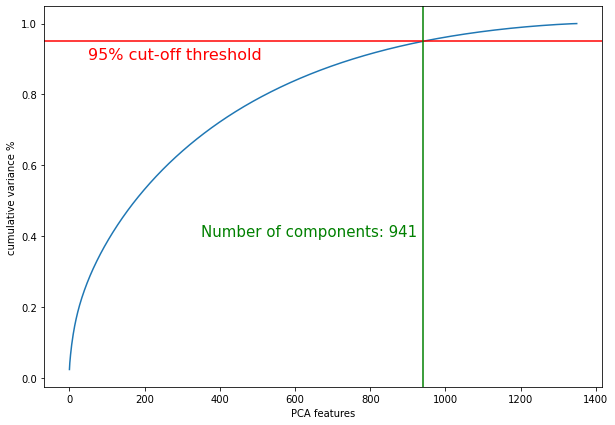

In [ ]:
pca_prueba = PCA().fit(tfidf_train.todense())
print(tfidf_train.shape)
pca_train = pca_prueba.transform(tfidf_train.todense())

features = range(pca_prueba.n_components_)
plt.figure(figsize=(10,7))
plt.plot(features, np.cumsum(pca_prueba.explained_variance_ratio_))
plt.xlabel('PCA features')
plt.ylabel('cumulative variance %')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(50, 0.9, '95% cut-off threshold', color = 'red', fontsize=16)

count=0
for valor in (np.cumsum(pca_prueba.explained_variance_ratio_)):
  if valor >= 0.95:
    print('Número de componentes: ', count)
    break
  count=count+1

plt.axvline(x=count, color='g', linestyle='-')
plt.text(350,0.4, f'Number of components: {count}', color='g', fontsize=15)

En teoría, estos 941 componentes deberían explicar correctamente la varianza del 95% de los datos. Por tanto, vamos a indicarlos para realizar el PCA:

In [ ]:
pca = PCA(n_components=941)
pca.fit(tfidf_train.todense())
pca_train = pca.transform(tfidf_train.todense())
pca_train.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



(3500, 941)

In [ ]:
type_names = [x.lower() for x in type_names]
type_names

['alzheimer', 'breast_cancer', 'bladder_cancer', 'negative', 'cervical_cancer']

A continuación, vamos a representar los datos (cada uno correspondiente a un *abstract*), coloreados en base a la patología o, mejor dicho, tipo de documento al que pertenecen (alzheimer, breast_cancer, bladder_cancer, negative o cervical_cancer). Para saber qué componentes dibujar, vamos a determinar qué componentes explican más la varianza:

<BarContainer object of 941 artists>

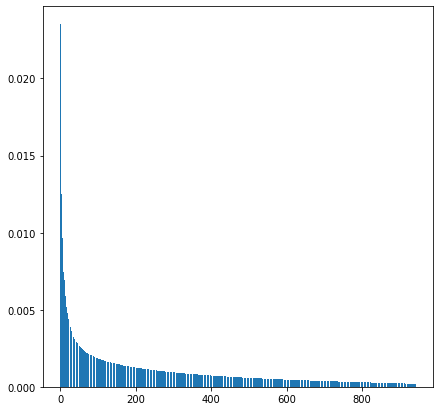

In [ ]:
plt.figure(figsize=(7,7))
plt.bar(range(1,942),pca.explained_variance_ratio_)

Como podemos apreciar, las dos primeras componentes parecen explicar más la varianza (si bien no demasiada), por lo que representaremos estas dos:

Text(0, 0.5, 'PCA 2')

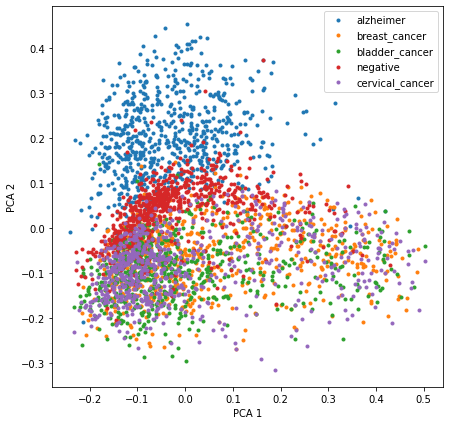

In [ ]:
plt.figure(figsize=(7,7))
for name in type_names:
    plt.plot(pca_train[y_train==name,0],
             pca_train[y_train==name,1], '.', label=name)
plt.legend();
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

Podemos apreciar, representando estas dos componentes, varios grupos en base a nuestros datos reales y el tipo de documento al que pertenecen. Por ejemplo, podemos definir un grupo o cluster bastante bien definido para los *abstracts* que pertenecen al grupo del Alzheimer, así como para "cervical_cancer" o "negative", siendo los de "breast_cancer" y "bladder_cancer" algo más difusos.

Posteriormente, con nuestro modelo de clustering usando K-means, trataremos de agrupar los textos de forma lo más parecida posible a como están agrupados en realidad, como vemos en la gráfica superior, en base al grupo al que pertenecen.

A continuación, vamos a generar la gráfica anterior en 3 dimensiones:

In [ ]:
import plotly.offline as py  # !pip install plotly
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

pc_x = 0
pc_y = 1
pc_z = 2

pcs_names = ["comp.princ. "+str(i) for i in range(pca.n_components_)]
colors = ['green', 'blue', 'red', 'orange', 'yellow', 'magenta', 'lightblue']
colors = 10*colors
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['square', 'circle-open', 'circle', 'diamond', 'cross']
markers = 10*markers

data = []

for name,c,m in zip(type_names,colors,markers):
    data.append(go.Scatter3d(x=pca_train[y_train==name,pc_x],
                             y=pca_train[y_train==name,pc_y],
                             z=pca_train[y_train==name,pc_z],
                             mode='markers',
                             name=name,
                             marker=dict(size=3, color=c, symbol=m, opacity=0.9)))

layout = go.Layout(title='Espacio PCA',
                   scene={"xaxis":{"title":pcs_names[pc_x]},
                          "yaxis":{"title":pcs_names[pc_y]},
                          "zaxis":{"title":pcs_names[pc_z]},
                         }
                  )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

py.plot(fig, filename = "grafica.html", auto_open=False); # Grabar figura en html

A continuación, vamos a generar la gráfica anterior de nuevo en 2 dimensiones, pero permitiendo al usuario explorar los *abstracts* y comprobar que, efectivamente, pertenecen al grupo al que están asignados. Como se ha indicado anteriormente, con K-means, trataremos de agrupar los textos con un modelo de aprendizaje automático, de forma lo más parecida posible a como vemos en la gráfica inferior.

In [ ]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, LabelSet, ColumnDataSource, Range1d
from bokeh.plotting import figure, show, output_notebook

# we select the principal components we will use for visualization
pc_x = 0
pc_y = 1

Xproj = pca_train[:,[pc_x,pc_y]]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# defining the chart
output_notebook()
p = bp.figure(plot_width=700, plot_height=600,
              title="Documents, PCA space",
              tools="pan,wheel_zoom,box_zoom,reset,hover,save",
              x_axis_label=pcs_names[pc_x],
              y_axis_label=pcs_names[pc_y],              
              #x_axis_type=None, y_axis_type=None,
              min_border=1)
p.title.text_font_size = '16pt'
p.xaxis.axis_label_text_font_style='normal'
p.xaxis.axis_label_text_font_size='16pt'
p.yaxis.axis_label_text_font_style='normal'
p.yaxis.axis_label_text_font_size='16pt'

p.xgrid.visible = False
p.ygrid.visible = False

for name,color,marker in zip(type_names,colors,markers):
    inds = np.where(y_train==name)[0]
    dictf = {'x':Xproj[inds,0],
             'y':Xproj[inds,1],
             'class':len(inds)*[name],
             'id':data_train["id"].values[inds],
             'title':data_train["title"].values[inds],
             'abstract':[t[:500] for t in data_train["abstract"].values[inds]]
            }
    p.scatter(x='x', y='y', source=ColumnDataSource(dictf), color=color, legend_label=name)
    hover = p.select(dict(type=HoverTool))
    hover.tooltips={"Type":"@class",
                    "ID":"@id",
                    "Title":"@title",
                    "Abstract":"@abstract"}
show(p)

#### **1.6.1.2: Modelo de clusterización (*K-means*)**

Tras realizar el análisis de los componentes principales y reducir la dimensionalidad de los datos, vamos a generar un modelo de aprendizaje automático no supervisado por medio del algoritmo ***K-means***. Este algoritmo nos permitirá agrupar los datos en distintos grupos o clusters, tratando de que éstos sean lo más parecidos posible a los grupos que veíamos al dibujar las dos primeras componentes principales, como se aprecia en la gráfica superior.

Para ello, usaremos los datos obtenidos tras reducir la dimensionalidad del *training set* original (y tras haber aplicado el método TF-IDF), por lo que el *performance* de este modelo de aprendizaje automático depende directamente del número de componentes elegido para el PCA. Recordemos que habíamos escogido 941 componentes.

En las siguientes celdas de código, se tomarán los datos transformados tras la reducción de dimensionalidad y aplicaremos el llamado "método del codo" (del inglés, *elbow criterion*) para seleccionar el número de clusters en el cual se produzca un cambio abrupto en la gráfica de la varianza intra-cluster (del inglés, *within-cluster sum of square*) frente al número de clusters. Este número de clusters k al que se produzca dicho cambio será el óptimo valor para el modelo.

Además, también evaluaremos el llamado índice de Calinski-Harabasz, que es el ratio de la suma de la dispersión inter-cluster y la dispersión intra-cluster para todos los clusters. A mayor valor para este índice, mejor será el *performance* del modelo. Un índice alto significa que los clusters son densos y están bien separados. 

Por tanto, para k posibles clusters, vamos a evaluar para cada uno su índice de Calinski-Harabasz, escogiendo el valor de k que maximice este índice, y en donde se produzca ese *elbow point*, algo que podemos determinar con *kmeans.inertia_*.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as qmetric

X_clustering = pca_train

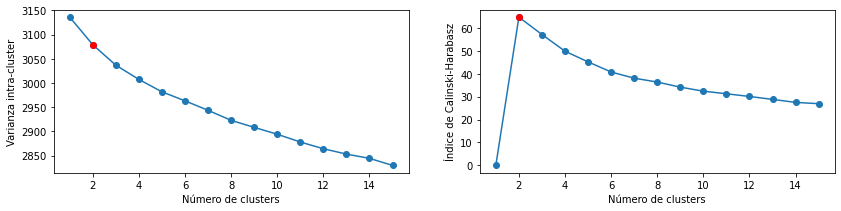


Índice de Calinski-Harabasz para el mejor número de clusters: 64.74588788628894


In [ ]:
from sklearn.cluster import KMeans

Nclusters_max = 15 #vamos a evaluar hasta 15 clusters, y escoger el más óptimo.
Nrepetitions = 10

qualities = []
inertias = []
models = []
for k in range(1,Nclusters_max+1):
    kmeans = KMeans(n_clusters=k,
                    init='k-means++', n_init=Nrepetitions,
                    max_iter=500, random_state=2)    
    kmeans.fit(X_clustering)
    models.append(kmeans)
    inertias.append(kmeans.inertia_)
    if k >1:
        qualities.append(qmetric(X_clustering, kmeans.labels_))
    else:
        qualities.append(0)

i = np.argmax(qualities)
best_model = models[i]
n_clusters = best_model.n_clusters

fig = plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.plot(range(1,Nclusters_max+1), inertias, marker='o')
plt.plot(n_clusters, inertias[i], "or")
plt.xlabel('Número de clusters')
plt.ylabel("Varianza intra-cluster")

ax = plt.subplot(1,2,2)
plt.plot(range(1,Nclusters_max+1), qualities, marker='o')
plt.plot(n_clusters, qualities[i], "or")
plt.xlabel('Número de clusters')
plt.ylabel("Índice de Calinski-Harabasz")
plt.show()

print("\nÍndice de Calinski-Harabasz para el mejor número de clusters:",qualities[i])

Como podemos apreciar, parece ser que el mejor número de clusters es 2. Esto, para empezar, no es lo que buscamos, ya que lo mejor sería que fuese 5, uno para cada tipo de documento. Además, el índice de Calinski-Harabasz es solo 64, el cual es un valor bastante bajo.

Estos clusters pueden ser representados de la siguiente forma, para las dos primeras componentes principales:

[1 1 1 ... 0 1 1]


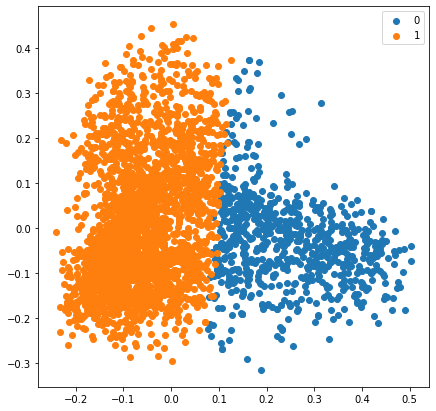

In [ ]:
cluster_ids = best_model.predict(X_clustering)
print(cluster_ids)

#Getting unique labels
 
u_labels = np.unique(cluster_ids)
 
#plotting the results:
 
plt.figure(figsize=(7,7))
for i in u_labels:
    plt.scatter(pca_train[cluster_ids == i , 0] , pca_train[cluster_ids == i , 1] , label = i)
plt.legend()
plt.show()

Si comparamos esta gráfica con la obtenida para el PCA:

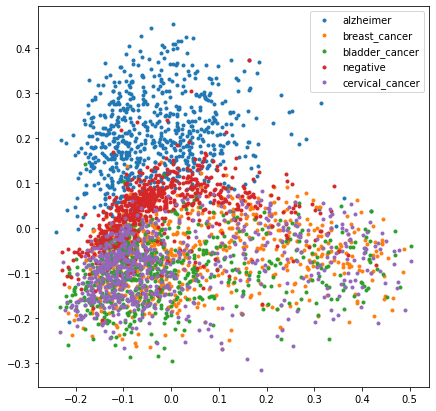

In [ ]:
plt.figure(figsize=(7,7))
for name in type_names:
    plt.plot(pca_train[y_train==name,0],
             pca_train[y_train==name,1], '.', label=name)
plt.legend();

No es la agrupación que esperaríamos. Esto también puede comprobarse si guardamos los datos en una tabla:

In [ ]:
df_aux = pd.DataFrame({"real":y_train.values,
                       "cluster_id":cluster_ids})
df_aux

real  cluster_id
0      bladder_cancer           1
1      bladder_cancer           1
2       breast_cancer           1
3       breast_cancer           1
4      bladder_cancer           1
...               ...         ...
3495        alzheimer           0
3496   bladder_cancer           1
3497    breast_cancer           0
3498         negative           1
3499  cervical_cancer           1

[3500 rows x 2 columns]

In [ ]:
df_aux.groupby(["cluster_id","real"])[["cluster_id"]].count()

cluster_id
cluster_id real                       
0          alzheimer                55
           bladder_cancer          142
           breast_cancer           268
           cervical_cancer         189
           negative                 87
1          alzheimer               645
           bladder_cancer          558
           breast_cancer           432
           cervical_cancer         511
           negative                613

Como vemos, en cada cluster de nuestro modelo más óptimo, para 941 componentes, hay *abstracts* de cada grupo, sin haber una distinción clara. Por tanto, **este modelo no es el más apropiado**.

### **1.6.2: EXPERIMENTO 2**

En vista de lo ocurrido para el experimento anterior, vamos a probar a generar un modelo tras un PCA con un menor número de componentes. En este caso, vamos a probar con 3 componentes para el PCA.

#### **1.6.2.1: Reducción de la dimensionalidad: PCA**

In [ ]:
pca = PCA(n_components=3)
pca.fit(tfidf_train.todense())
pca_train = pca.transform(tfidf_train.todense())
pca_train.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



(3500, 3)

Text(0, 0.5, 'PCA 2')

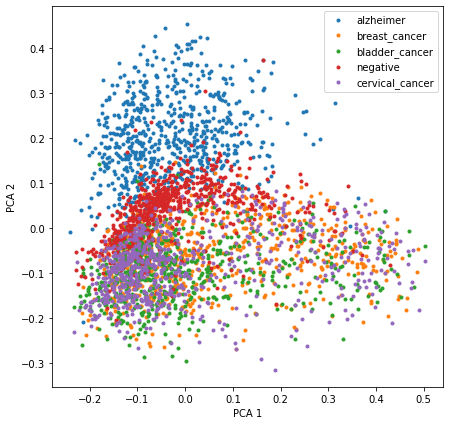

In [ ]:
plt.figure(figsize=(7,7))
for name in type_names:
    plt.plot(pca_train[y_train==name,0],
             pca_train[y_train==name,1], '.', label=name)
plt.legend();
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

Podemos apreciar, representando estas dos componentes, varios grupos en base a nuestros datos reales y el tipo de documento al que pertenecen. Por ejemplo, podemos definir un grupo o cluster bastante bien definido para los *abstracts* que pertenecen al grupo del Alzheimer, así como para "cervical_cancer" o "negative", siendo los de "breast_cancer" y "bladder_cancer" algo más difusos.

Posteriormente, con nuestro modelo de clustering usando K-means, trataremos de agrupar los textos de forma lo más parecida posible a como están agrupados en realidad, como vemos en la gráfica superior, en base al grupo al que pertenecen.

#### **1.6.2.2: Modelo de clusterización (*K-means*)**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as qmetric

X_clustering = pca_train

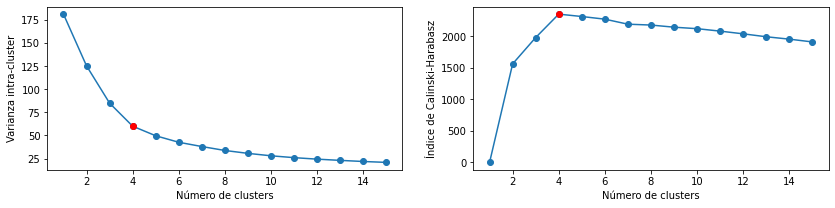


Índice de Calinski-Harabasz para el mejor número de clusters: 2350.45452015185


In [ ]:
from sklearn.cluster import KMeans

Nclusters_max = 15 #vamos a evaluar hasta 15 clusters, y escoger el más óptimo.
Nrepetitions = 10

qualities = []
inertias = []
models = []
for k in range(1,Nclusters_max+1):
    kmeans = KMeans(n_clusters=k,
                    init='k-means++', n_init=Nrepetitions,
                    max_iter=500, random_state=2)    
    kmeans.fit(X_clustering)
    models.append(kmeans)
    inertias.append(kmeans.inertia_)
    if k >1:
        qualities.append(qmetric(X_clustering, kmeans.labels_))
    else:
        qualities.append(0)

i = np.argmax(qualities)
best_model = models[i]
n_clusters = best_model.n_clusters

fig = plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.plot(range(1,Nclusters_max+1), inertias, marker='o')
plt.plot(n_clusters, inertias[i], "or")
plt.xlabel('Número de clusters')
plt.ylabel("Varianza intra-cluster")

ax = plt.subplot(1,2,2)
plt.plot(range(1,Nclusters_max+1), qualities, marker='o')
plt.plot(n_clusters, qualities[i], "or")
plt.xlabel('Número de clusters')
plt.ylabel("Índice de Calinski-Harabasz")
plt.show()

print("\nÍndice de Calinski-Harabasz para el mejor número de clusters:",qualities[i])

Como podemos apreciar, parece ser que el mejor número de clusters es 4. Esto no es lo que buscamos, ya que lo mejor sería que fuese 5, uno para cada tipo de documento, aunque observamos una mejora con respecto al experimento anterior.

Estos clusters pueden ser representados de la siguiente forma, para las dos primeras componentes principales:

[0 0 0 ... 1 2 0]


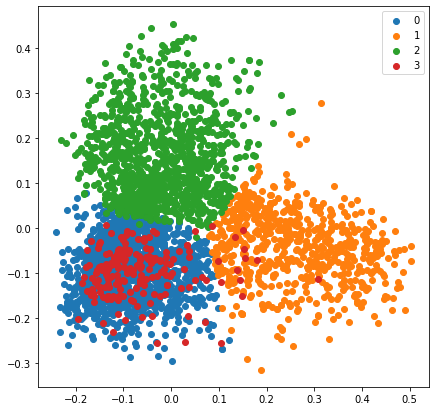

In [ ]:
cluster_ids = best_model.predict(X_clustering)
print(cluster_ids)

#Getting unique labels
 
u_labels = np.unique(cluster_ids)
 
#plotting the results:
 
plt.figure(figsize=(7,7))
for i in u_labels:
    plt.scatter(pca_train[cluster_ids == i , 0] , pca_train[cluster_ids == i , 1] , label = i)
plt.legend()
plt.show()

Si comparamos esta gráfica con la obtenida para el PCA:

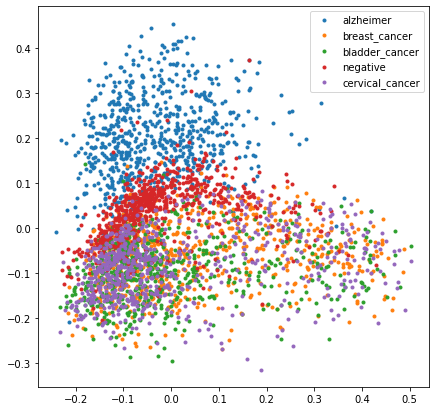

In [ ]:
plt.figure(figsize=(7,7))
for name in type_names:
    plt.plot(pca_train[y_train==name,0],
             pca_train[y_train==name,1], '.', label=name)
plt.legend();

No es la agrupación que esperaríamos, aunque es mucho más similar a la del PCA en comparación con el experimento anterior. Esto también puede comprobarse si guardamos los datos en una tabla:

In [ ]:
df_aux = pd.DataFrame({"real":y_train.values,
                       "cluster_id":cluster_ids})
df_aux

real  cluster_id
0      bladder_cancer           0
1      bladder_cancer           0
2       breast_cancer           0
3       breast_cancer           2
4      bladder_cancer           0
...               ...         ...
3495        alzheimer           1
3496   bladder_cancer           0
3497    breast_cancer           1
3498         negative           2
3499  cervical_cancer           0

[3500 rows x 2 columns]

In [ ]:
df_aux.groupby(["cluster_id","real"])[["cluster_id"]].count()

cluster_id
cluster_id real                       
0          alzheimer                22
           bladder_cancer          537
           breast_cancer           396
           cervical_cancer         315
           negative                218
1          alzheimer                13
           bladder_cancer          138
           breast_cancer           255
           cervical_cancer         173
           negative                 70
2          alzheimer               665
           bladder_cancer           25
           breast_cancer            47
           cervical_cancer          23
           negative                408
3          breast_cancer             2
           cervical_cancer         189
           negative                  4

Como vemos, para este experimento donde el número de componentes del PCA ha sido 3, el modelo más óptimo ha sido para 4 clusters, que parecen asemejarse más a las agrupaciones reales de los *abstracts* de los *datasets*. Aunque hay clusters, como el 0, donde no hay una predominancia clara de ningún grupo, hay otros en los que sí, como el cluster 2 o el 3, donde predominan los *abstracts* de Alzheimer y cáncer de cuello de útero, respectivamente.

Además, por ejemplo, para el cluster 2, donde predominan los de Alzheimer, este cluster, representado en base a los dos primeros componentes principales, ocupa la misma zona que el cluster real de los *abstracts* de Alzheimer en la gráfica del PCA. Esto significa que, con estos 3 componentes del PCA, el modelo de clustering es **mucho mejor** y está clasificando mejor los *abstracts* en comparación con el modelo del experimento anterior.

### **1.6.3: EXPERIMENTO 3**

A continuación, vamos a probar a generar un modelo tras un PCA con 4 componentes.

#### **1.6.3.1: Reducción de la dimensionalidad: PCA**

In [ ]:
pca = PCA(n_components=4)
pca.fit(tfidf_train.todense())
pca_train = pca.transform(tfidf_train.todense())
pca_train.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



(3500, 4)

Text(0, 0.5, 'PCA 2')

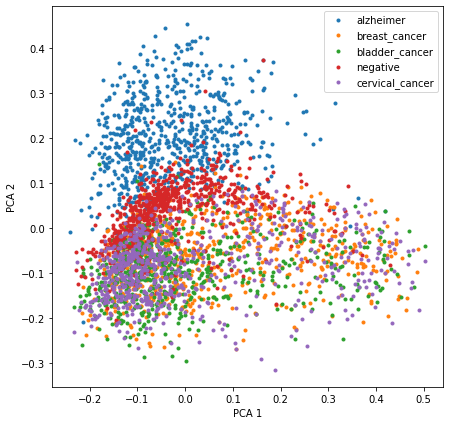

In [ ]:
plt.figure(figsize=(7,7))
for name in type_names:
    plt.plot(pca_train[y_train==name,0],
             pca_train[y_train==name,1], '.', label=name)
plt.legend();
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

Podemos apreciar, representando estas dos componentes, varios grupos en base a nuestros datos reales y el tipo de documento al que pertenecen. Por ejemplo, podemos definir un grupo o cluster bastante bien definido para los *abstracts* que pertenecen al grupo del Alzheimer, así como para "cervical_cancer" o "negative", siendo los de "breast_cancer" y "bladder_cancer" algo más difusos.

Posteriormente, con nuestro modelo de clustering usando K-means, trataremos de agrupar los textos de forma lo más parecida posible a como están agrupados en realidad, como vemos en la gráfica superior, en base al grupo al que pertenecen.

#### **1.6.3.2: Modelo de clusterización (*K-means*)**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as qmetric

X_clustering = pca_train

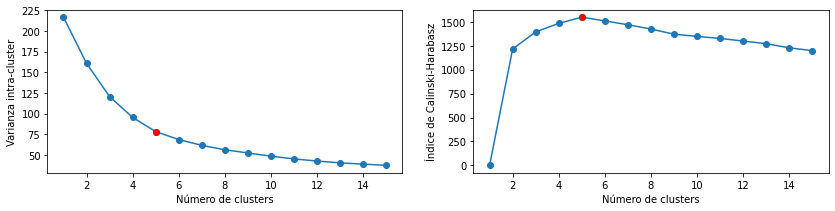


Índice de Calinski-Harabasz para el mejor número de clusters: 1549.8958861690962


In [ ]:
from sklearn.cluster import KMeans

Nclusters_max = 15 #vamos a evaluar hasta 15 clusters, y escoger el más óptimo.
Nrepetitions = 10

qualities = []
inertias = []
models = []
for k in range(1,Nclusters_max+1):
    kmeans = KMeans(n_clusters=k,
                    init='k-means++', n_init=Nrepetitions,
                    max_iter=500, random_state=2)    
    kmeans.fit(X_clustering)
    models.append(kmeans)
    inertias.append(kmeans.inertia_)
    if k >1:
        qualities.append(qmetric(X_clustering, kmeans.labels_))
    else:
        qualities.append(0)

i = np.argmax(qualities)
best_model = models[i]
n_clusters = best_model.n_clusters

fig = plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.plot(range(1,Nclusters_max+1), inertias, marker='o')
plt.plot(n_clusters, inertias[i], "or")
plt.xlabel('Número de clusters')
plt.ylabel("Varianza intra-cluster")

ax = plt.subplot(1,2,2)
plt.plot(range(1,Nclusters_max+1), qualities, marker='o')
plt.plot(n_clusters, qualities[i], "or")
plt.xlabel('Número de clusters')
plt.ylabel("Índice de Calinski-Harabasz")
plt.show()

print("\nÍndice de Calinski-Harabasz para el mejor número de clusters:",qualities[i])

Como podemos apreciar, parece ser que el mejor número de clusters es 5. Esto es, efectivamente, lo que buscábamos, es decir, un cluster para cada tipo de documento. Sin embargo, vemos que el índice de Calinski-Harabasz para este caso no es tan alto como para el experimento anterior, aunque sigue siendo bastante bueno, indicando una buena separación entre los clusters.

Estos clusters pueden ser representados de la siguiente forma, para las dos primeras componentes principales:

[1 1 1 ... 2 0 1]


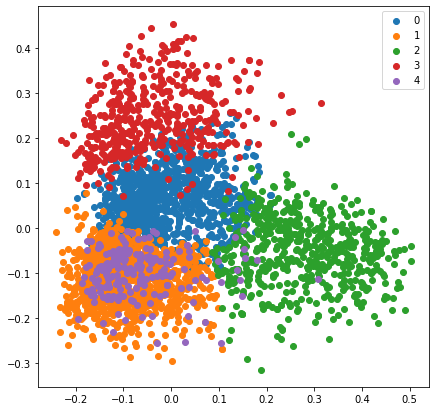

In [ ]:
cluster_ids = best_model.predict(X_clustering)
print(cluster_ids)

#Getting unique labels
 
u_labels = np.unique(cluster_ids)
 
#plotting the results:
 
plt.figure(figsize=(7,7))
for i in u_labels:
    plt.scatter(pca_train[cluster_ids == i , 0] , pca_train[cluster_ids == i , 1] , label = i)
plt.legend()
plt.show()

Si comparamos esta gráfica con la obtenida para el PCA:

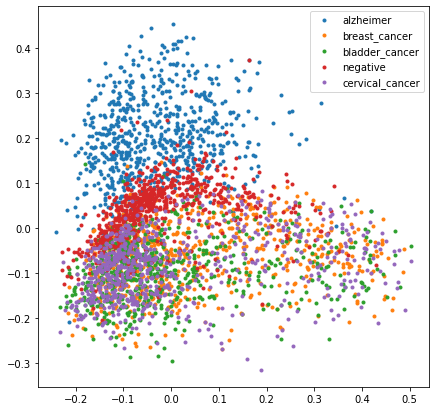

In [ ]:
plt.figure(figsize=(7,7))
for name in type_names:
    plt.plot(pca_train[y_train==name,0],
             pca_train[y_train==name,1], '.', label=name)
plt.legend();

En este caso, la agrupación de los clusters obtenidos por medio del modelo de clustering es muy similar a la agrupación real de los *abstracts*, como vemos en la gráfica superior. Por tanto, esto parece indicar que nuestro modelo tiene un buen *performance* a la hora de agrupar los textos. Esto también puede comprobarse si guardamos los datos en una tabla:

In [ ]:
df_aux = pd.DataFrame({"real":y_train.values,
                       "cluster_id":cluster_ids})
df_aux

real  cluster_id
0      bladder_cancer           1
1      bladder_cancer           1
2       breast_cancer           1
3       breast_cancer           0
4      bladder_cancer           0
...               ...         ...
3495        alzheimer           2
3496   bladder_cancer           1
3497    breast_cancer           2
3498         negative           0
3499  cervical_cancer           1

[3500 rows x 2 columns]

In [ ]:
df_aux.groupby(["cluster_id","real"])[["cluster_id"]].count()

cluster_id
cluster_id real                       
0          alzheimer               239
           bladder_cancer          109
           breast_cancer           158
           cervical_cancer          91
           negative                512
1          alzheimer                12
           bladder_cancer          463
           breast_cancer           314
           cervical_cancer         264
           negative                121
2          alzheimer                10
           bladder_cancer          127
           breast_cancer           224
           cervical_cancer         154
           negative                 49
3          alzheimer               439
           bladder_cancer            1
           breast_cancer             1
           cervical_cancer           1
           negative                 13
4          breast_cancer             3
           cervical_cancer         190
           negative                  5

Como vemos, para este experimento donde el número de componentes del PCA ha sido 4, el modelo más óptimo ha sido para 5 clusters, que parecen asemejarse mucho más a las agrupaciones reales de los *abstracts* de los *datasets*. Aunque hay clusters, como el 2, donde no hay una predominancia clara de ningún grupo, en los demás sí que existe esta predominancia.

Por ejemplo, para el cluster 3, donde predominan los *abstracts* de Alzheimer, este cluster, representado en base a los dos primeros componentes principales, ocupa la misma zona que el cluster real de los *abstracts* de Alzheimer en la gráfica del PCA. Esto también se observa para los clusters 0, 1 y 4. Esto significa que, con estos 4 componentes del PCA, el modelo de clustering es **mucho mejor** y está clasificando mejor los *abstracts* en comparación con los modelos de los experimentos anteriores. 

### **1.6.4: EXPERIMENTO 4**

A continuación, vamos a probar a generar un modelo tras un PCA con 5 componentes.

#### **1.6.4.1: Reducción de la dimensionalidad: PCA**

In [ ]:
pca = PCA(n_components=5)
pca.fit(tfidf_train.todense())
pca_train = pca.transform(tfidf_train.todense())
pca_train.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



(3500, 5)

Text(0, 0.5, 'PCA 2')

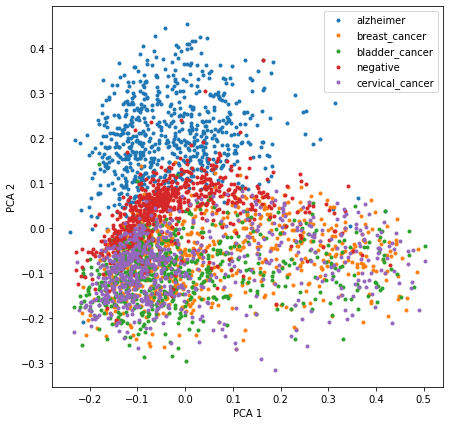

In [ ]:
plt.figure(figsize=(7,7))
for name in type_names:
    plt.plot(pca_train[y_train==name,0],
             pca_train[y_train==name,1], '.', label=name)
plt.legend();
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

Podemos apreciar, representando estas dos componentes, varios grupos en base a nuestros datos reales y el tipo de documento al que pertenecen. Por ejemplo, podemos definir un grupo o cluster bastante bien definido para los *abstracts* que pertenecen al grupo del Alzheimer, así como para "cervical_cancer" o "negative", siendo los de "breast_cancer" y "bladder_cancer" algo más difusos.

Posteriormente, con nuestro modelo de clustering usando K-means, trataremos de agrupar los textos de forma lo más parecida posible a como están agrupados en realidad, como vemos en la gráfica superior, en base al grupo al que pertenecen.

#### **1.6.4.2: Modelo de clusterización (*K-means*)**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as qmetric

X_clustering = pca_train

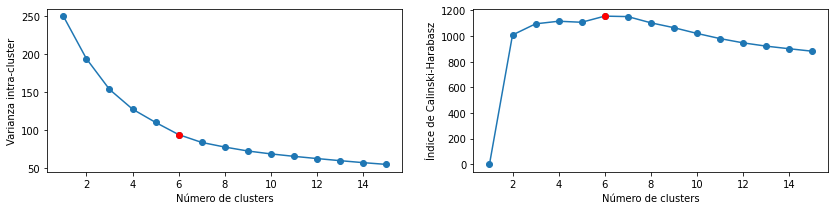


Índice de Calinski-Harabasz para el mejor número de clusters: 1155.954925960863


In [ ]:
from sklearn.cluster import KMeans

Nclusters_max = 15 #vamos a evaluar hasta 15 clusters, y escoger el más óptimo.
Nrepetitions = 10

qualities = []
inertias = []
models = []
for k in range(1,Nclusters_max+1):
    kmeans = KMeans(n_clusters=k,
                    init='k-means++', n_init=Nrepetitions,
                    max_iter=500, random_state=2)    
    kmeans.fit(X_clustering)
    models.append(kmeans)
    inertias.append(kmeans.inertia_)
    if k >1:
        qualities.append(qmetric(X_clustering, kmeans.labels_))
    else:
        qualities.append(0)

i = np.argmax(qualities)
best_model = models[i]
n_clusters = best_model.n_clusters

fig = plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.plot(range(1,Nclusters_max+1), inertias, marker='o')
plt.plot(n_clusters, inertias[i], "or")
plt.xlabel('Número de clusters')
plt.ylabel("Varianza intra-cluster")

ax = plt.subplot(1,2,2)
plt.plot(range(1,Nclusters_max+1), qualities, marker='o')
plt.plot(n_clusters, qualities[i], "or")
plt.xlabel('Número de clusters')
plt.ylabel("Índice de Calinski-Harabasz")
plt.show()

print("\nÍndice de Calinski-Harabasz para el mejor número de clusters:",qualities[i])

Como podemos apreciar, parece ser que el mejor número de clusters es 6. Este es un mayor número de clusters al que esperábamos, es decir, un cluster para cada tipo de documento. Aun así, vemos que el índice de Calinski-Harabasz para este caso ha disminuido respecto al experimento anterior pero sigue siendo alto y, por tanto, favorable.

Estos clusters pueden ser representados de la siguiente forma, para las dos primeras componentes principales:

[0 0 0 ... 2 1 0]


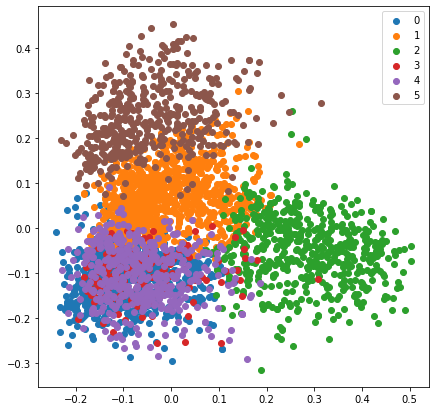

In [ ]:
cluster_ids = best_model.predict(X_clustering)
print(cluster_ids)

#Getting unique labels
 
u_labels = np.unique(cluster_ids)
 
#plotting the results:
 
plt.figure(figsize=(7,7))
for i in u_labels:
    plt.scatter(pca_train[cluster_ids == i , 0] , pca_train[cluster_ids == i , 1] , label = i)
plt.legend()
plt.show()

Si comparamos esta gráfica con la obtenida para el PCA:

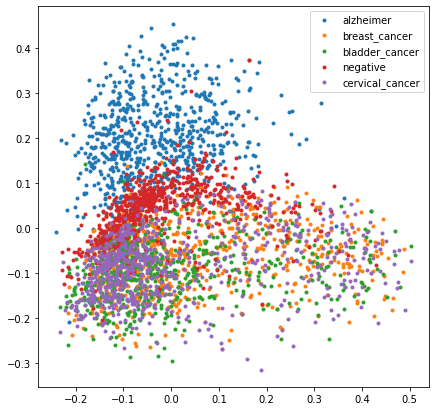

In [ ]:
plt.figure(figsize=(7,7))
for name in type_names:
    plt.plot(pca_train[y_train==name,0],
             pca_train[y_train==name,1], '.', label=name)
plt.legend();

En este caso, la agrupación de los clusters obtenidos por medio del modelo de clustering es similar a la agrupación real de los *abstracts*, como vemos en la gráfica superior, aunque con la presencia de un cluster adicional. No es la agrupación, de todos modos, que esperaríamos. Esto también puede comprobarse si guardamos los datos en una tabla:

In [ ]:
df_aux = pd.DataFrame({"real":y_train.values,
                       "cluster_id":cluster_ids})
df_aux

real  cluster_id
0      bladder_cancer           0
1      bladder_cancer           0
2       breast_cancer           0
3       breast_cancer           1
4      bladder_cancer           0
...               ...         ...
3495        alzheimer           1
3496   bladder_cancer           0
3497    breast_cancer           2
3498         negative           1
3499  cervical_cancer           0

[3500 rows x 2 columns]

In [ ]:
df_aux.groupby(["cluster_id","real"])[["cluster_id"]].count()

cluster_id
cluster_id real                       
0          alzheimer                12
           bladder_cancer          429
           breast_cancer           125
           cervical_cancer         218
           negative                117
1          alzheimer               250
           bladder_cancer           70
           breast_cancer           124
           cervical_cancer          75
           negative                479
2          alzheimer                 9
           bladder_cancer          123
           breast_cancer           208
           cervical_cancer         149
           negative                 49
3          breast_cancer             1
           cervical_cancer         170
           negative                  2
4          alzheimer                 5
           bladder_cancer           77
           breast_cancer           241
           cervical_cancer          87
           negative                 40
5          alzheimer               424
           bladder_cancer            1
           breast_cancer             1
           cervical_cancer           1
           negative                 13

Como vemos, para este experimento donde el número de componentes del PCA ha sido 5, el modelo más óptimo ha sido para 6 clusters, que parecen asemejarse a las agrupaciones reales de los *abstracts* de los *datasets*, aunque no tanto como en el experimento anterior, ya que en este caso hay un cluster más. Aun así, para este modelo, aunque hay clusters, como el 0, donde no hay una predominancia clara de ningún grupo, en los demás sí que existe esta predominancia.

Por ejemplo, para el cluster 5, donde predominan los *abstracts* de Alzheimer, este cluster, representado en base a los dos primeros componentes principales, ocupa la misma zona que el cluster real de los *abstracts* de Alzheimer en la gráfica del PCA, aunque hay muchos *abstracts* de Alzheimer que se encasillan dentro del cluster 1, donde predominan los *abstracts* de tipo *negative*. Este modelo, si bien parece tener un buen poder clasificador, no parece ser tan bueno como el modelo del experimento anterior, al tener un cluster adicional y un menor índice de Calinski-Harabasz. 

### **1.6.5: EXPERIMENTO 5**

A continuación, vamos a probar a generar un modelo tras un PCA con 6 componentes.

#### **1.6.5.1: Reducción de la dimensionalidad: PCA**

In [ ]:
pca = PCA(n_components=6)
pca.fit(tfidf_train.todense())
pca_train = pca.transform(tfidf_train.todense())
pca_train.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



(3500, 6)

Text(0, 0.5, 'PCA 2')

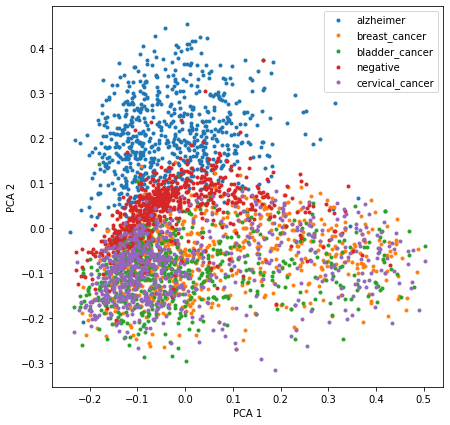

In [ ]:
plt.figure(figsize=(7,7))
for name in type_names:
    plt.plot(pca_train[y_train==name,0],
             pca_train[y_train==name,1], '.', label=name)
plt.legend();
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

Podemos apreciar, representando estas dos componentes, varios grupos en base a nuestros datos reales y el tipo de documento al que pertenecen. Por ejemplo, podemos definir un grupo o cluster bastante bien definido para los *abstracts* que pertenecen al grupo del Alzheimer, así como para "cervical_cancer" o "negative", siendo los de "breast_cancer" y "bladder_cancer" algo más difusos.

Posteriormente, con nuestro modelo de clustering usando K-means, trataremos de agrupar los textos de forma lo más parecida posible a como están agrupados en realidad, como vemos en la gráfica superior, en base al grupo al que pertenecen.

#### **1.6.5.2: Modelo de clusterización (*K-means*)**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as qmetric

X_clustering = pca_train

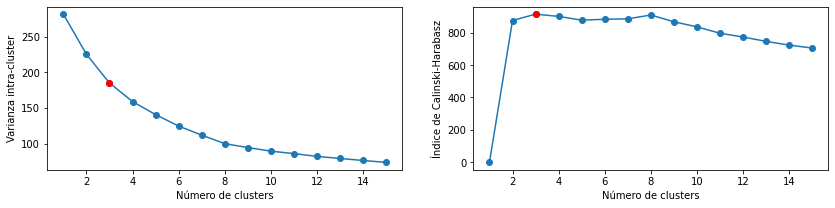


Índice de Calinski-Harabasz para el mejor número de clusters: 913.6514011481817


In [ ]:
from sklearn.cluster import KMeans

Nclusters_max = 15 #vamos a evaluar hasta 15 clusters, y escoger el más óptimo.
Nrepetitions = 10

qualities = []
inertias = []
models = []
for k in range(1,Nclusters_max+1):
    kmeans = KMeans(n_clusters=k,
                    init='k-means++', n_init=Nrepetitions,
                    max_iter=500, random_state=2)    
    kmeans.fit(X_clustering)
    models.append(kmeans)
    inertias.append(kmeans.inertia_)
    if k >1:
        qualities.append(qmetric(X_clustering, kmeans.labels_))
    else:
        qualities.append(0)

i = np.argmax(qualities)
best_model = models[i]
n_clusters = best_model.n_clusters

fig = plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.plot(range(1,Nclusters_max+1), inertias, marker='o')
plt.plot(n_clusters, inertias[i], "or")
plt.xlabel('Número de clusters')
plt.ylabel("Varianza intra-cluster")

ax = plt.subplot(1,2,2)
plt.plot(range(1,Nclusters_max+1), qualities, marker='o')
plt.plot(n_clusters, qualities[i], "or")
plt.xlabel('Número de clusters')
plt.ylabel("Índice de Calinski-Harabasz")
plt.show()

print("\nÍndice de Calinski-Harabasz para el mejor número de clusters:",qualities[i])

Como podemos apreciar, parece ser que el mejor número de clusters es 3. Esto no es, de nuevo, lo que buscamos, ya que lo mejor sería que fuese 5, uno para cada tipo de documento, algo que habíamos obtenido para el experimento 3. Además, el índice de Calinski-Harabasz ha bajado más respecto a los experimentos anteriores, si bien sigue siendo bastante alto.

Estos 3 clusters pueden ser representados de la siguiente forma, para las dos primeras componentes principales:

[2 2 2 ... 0 1 2]


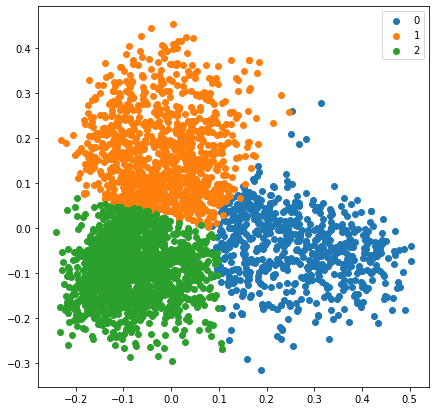

In [ ]:
cluster_ids = best_model.predict(X_clustering)
print(cluster_ids)

#Getting unique labels
 
u_labels = np.unique(cluster_ids)
 
#plotting the results:
 
plt.figure(figsize=(7,7))
for i in u_labels:
    plt.scatter(pca_train[cluster_ids == i , 0] , pca_train[cluster_ids == i , 1] , label = i)
plt.legend()
plt.show()

Si comparamos esta gráfica con la obtenida para el PCA:

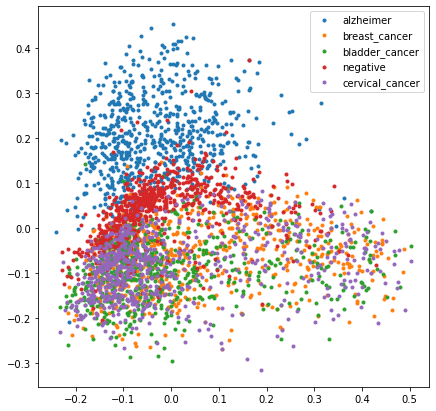

In [ ]:
plt.figure(figsize=(7,7))
for name in type_names:
    plt.plot(pca_train[y_train==name,0],
             pca_train[y_train==name,1], '.', label=name)
plt.legend();

En este caso, la agrupación de los clusters obtenidos por medio del modelo de clustering ya no es tan similar a la agrupación real de los *abstracts*, como vemos en la gráfica superior, a diferencia de lo que ocurría para experimentos anteriores. Esto también puede comprobarse si guardamos los datos en una tabla:

In [ ]:
df_aux = pd.DataFrame({"real":y_train.values,
                       "cluster_id":cluster_ids})
df_aux

real  cluster_id
0      bladder_cancer           2
1      bladder_cancer           2
2       breast_cancer           2
3       breast_cancer           1
4      bladder_cancer           2
...               ...         ...
3495        alzheimer           0
3496   bladder_cancer           2
3497    breast_cancer           0
3498         negative           1
3499  cervical_cancer           2

[3500 rows x 2 columns]

In [ ]:
df_aux.groupby(["cluster_id","real"])[["cluster_id"]].count()

cluster_id
cluster_id real                       
0          alzheimer                13
           bladder_cancer          135
           breast_cancer           257
           cervical_cancer         182
           negative                 69
1          alzheimer               662
           bladder_cancer           25
           breast_cancer            39
           cervical_cancer          19
           negative                375
2          alzheimer                25
           bladder_cancer          540
           breast_cancer           404
           cervical_cancer         499
           negative                256

Como vemos, para este experimento donde el número de componentes del PCA ha sido 6, el modelo más óptimo ha sido para 3 clusters, que esta vez se parecen menos a las agrupaciones reales de los *abstracts* de los *datasets*. En este caso, si bien hay en todos los clusters algún grupo que sea mayoritario, no existe una predominancia de ninguno de ellos en ningún caso.

Este modelo, por tanto, no parece ser tan bueno como el modelo del experimento número 3, al tener un menor número de clusters y un menor índice de Calinski-Harabasz. 

### **1.6.6: CONCLUSIONES**

A modo de conclusión, podemos establecer que este modelo de clustering, para valores altos del número de componentes de la PCA, no tiene una buena capacidad de agrupamiento o clustering, sino que ésta es mejor para valores pequeños, concretamente para un número de componentes menor a 6, ya que hemos visto que a partir de este valor el número de clusters obtenidos en el mejor modelo decrece, y de hecho se mantiene en 2 clusters a partir de los 9 componentes (esto no se ha mostrado en el notebook para que no sea demasiado extenso), decreciendo asimismo el índice de Calinski-Harabasz a medida que aumenta el número de componentes del PCA. 

Concretamente, hemos visto que el mejor modelo de clustering se obtiene para un número de componentes igual a 4, donde se obtiene un modelo de clustering que genera 5 clusters y que posee un buen índice de Calinski-Harabasz. Aunque el modelo obtenido con 3 componentes del experimento 2 tenía un mayor índice de Calinski-Harabasz que este modelo, como lo ideal era obtener 5 clusters, es a raíz de esto por lo que se ha considerado que el mejor es aquel obtenido con 4 componentes para el PCA, aunque su índice sea menor, que aun así sigue siendo muy alto y por tanto indica un buen grado de separación entre los clusters.

Cabe recalcar que, para todos los modelos de los experimentos anteriores, en cada cluster había casi siempre un grupo (de los 5 existentes para los *abstracts* que estamos manejando en esta práctica) que predominaba en el mismo, pero esto no significa que no hubiese *abstracts* de dicho grupo que estuviesen, de forma minoritaria, en otros clusters. Naturalmente, lo ideal sería que el mayor número de *abstracts* de un grupo o clase estuviesen dentro del mismo cluster, pero no ha sido posible obtener un modelo de clustering tan idóneo. Por tanto, cuando decimos que el modelo del experimento 3 es el más apropiado, hay que tener esta última consideración en mente.

## **1.7: Resumen**

### **1.7.1: Técnicas de pre-procesado**

Tal y como hemos visto al inicio de la práctica, tras cargar los paquetes necesarios y los *datasets*, hemos tenido que preprocesar los *abstracts* antes de su vectorización, necesaria para los modelos de clasificación y de clustering. Para ello, hemos eliminado los espaciados repetidos, borrado las cabeceras de las distintas secciones de cada *abstract* para todas las clases (alzheimer, bladder_cancer, breast_cancer, negative y cervical_cancer), transformado los *datasets* en minúscula, eliminado los *stopwords* y los signos de puntuación, y también hemos simplificado los *abstracts* por medio de la herramienta *lemmatizer*. Al final, obteníamos la tabla siguiente:

In [ ]:
data_lower

id  \
0     27816982   
1     27092587   
2     27486640   
3     27382284   
4     27354798   
...        ...   
4995  28000900   
4996  26919225   
4997  27199504   
4998  27222134   
4999  27377093   

                                                                                                    title  \
0                                 cytology at the time of some things to think about when discussing hpv.   
1     production of precursors for anti-alzheimer drugs: asymmetric bioreduction in a packed-bed biore...   
2                                   empagliflozin (jardiance). type 2 diabetes: no rush to use this drug.   
3     a stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...   
4     elimination of the biphasic pharmacodynamics of 15d-pgj2 by controlling its release from a nanoe...   
...                                                                                                   ...   
4995  mir-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...   
4996  the role of urinary ph in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...   
4997  prognostic and clinicopathological significance of downregulated p16 expression in patients with...   
4998                           p21 and p27 immunoexpression in upper urinary tract urothelial carcinomas.   
4999                                      lymphoepithelioma-like carcinoma of the bladder: a case report.   

                                                                                                 abstract  \
0     'in the current 28 member states of the european union (eu), approximately 34,000 new cases of c...   
1     (s)-1-phenylethanol derivatives, which are the precursors of many pharmacological products, have...   
2     * in early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...   
3     10-hydroxycamptothecin (10-hcpt) is a promising anticancer drug with a wide spectrum of antitumo...   
4     15-deoxy-delta12,14-prostaglandin j2 (15d-pgj2) has a dual action of stimulating anti-inflammati...   
...                                                                                                   ...   
4995  micrornas (mirnas), a class of small non-coding rna molecules, can regulate gene expression by i...   
4996  o-phenylphenol (opp) is a widely used fungicide and antibacterial agent that at high doses has b...   
4997  p16, encoded by the cdkn2a gene, is a tumor suppressor that has been widely studied in cancer re...   
4998  p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...   
4999  type of low differentiated carcinoma of the nasopharyngeal region characterized by marked infilt...   

                                                                                                     text  \
0     'in current 28 member state european union eu approximately 34,000 new case cervical cancer 13,0...   
1     -1-phenylethanol derivative precursor many pharmacological product also used anti-alzheimer drug...   
2     early 2016 metformin monotherapy remains treatment choice patient type 2 diabetes several altern...   
3     10-hydroxycamptothecin 10-hcpt promising anticancer drug wide spectrum antitumor activity due po...   
4     15-deoxy-delta12,14-prostaglandin j2 15d-pgj2 dual action stimulating anti-inflammation anti-pro...   
...                                                                                                   ...   
4995  micrornas mirnas class small non-coding rna molecule regulate gene expression interacting 3'-unt...   
4996  o-phenylphenol opp widely used fungicide antibacterial agent high dos shown cause bladder cancer...   
4997  p16 encoded cdkn2a gene tumor suppressor widely studied cancer research however relationship p16...   
4998  p21 p27 member cyclin-dependent kinase family function tumor suppressor involved 

---

**INCISO**: En un principio, también se iban a procesar los números de los textos, por medio del siguiente comando:

In [ ]:
data_processed_numbers=data_lower["text"].apply(lambda x: re.sub('([^A-Za-z\d-])[\d]+\.*[\d]*', r'\1NUM', x))
data_processed_numbers

0       'in current NUM member state european union eu approximately NUM,NUM new case cervical cancer NU...
1       -1-phenylethanol derivative precursor many pharmacological product also used anti-alzheimer drug...
2       early NUM metformin monotherapy remains treatment choice patient type NUM diabetes several alter...
3       10-hydroxycamptothecin NUM-hcpt promising anticancer drug wide spectrum antitumor activity due p...
4       15-deoxy-delta12,NUM-prostaglandin j2 NUMd-pgj2 dual action stimulating anti-inflammation anti-p...
                                                       ...                                                 
4995    micrornas mirnas class small non-coding rna molecule regulate gene expression interacting NUM'-u...
4996    o-phenylphenol opp widely used fungicide antibacterial agent high dos shown cause bladder cancer...
4997    p16 encoded cdkn2a gene tumor suppressor widely studied cancer research however relationship p16...
4998    p21 p27 member cycli

Sin embargo, este procedimiento no mejoraba el *performance* de los modelos de clasificación, mientras que empeoraba el del modelo de clustering, fuera cual fuera el valor del número de componentes del PCA, ya que en ningún momento se obtenían 5 clusters ni buenos índices de Calinski-Harabasz. Ante esto, se decidió no incluir este paso dentro del preprocesado de los textos.

---

### **1.7.2: Técnicas de "word-embedding"**

Para la construcción del vocabulario, se ha recurrido al método de embedding TF-IDF, que transforma las palabras en vectores numéricos, como se ha detallado anteriormente. Para este caso, el único parámetro que se ha indicado ha sido *min_df=50*, es decir, que se ignorasen aquellas palabras cuya frecuencia fuese menor a 50 en los textos.

### **1.7.3: Modelos de clasificación**

Si recordamos, hemos evaluado cuatro principales modelos de clasificación, los cuales han sido obtenidos tras determinar los valores óptimos de varios de sus parámetros por medio de *Pipelines*. La calidad de los modelos se ha medido por medio de su *accuracy* tanto sobre el *training set* como el *test set*. A continuación, se muestra una tabla resumiendo los resultados obtenidos para cada modelo de clasificación:

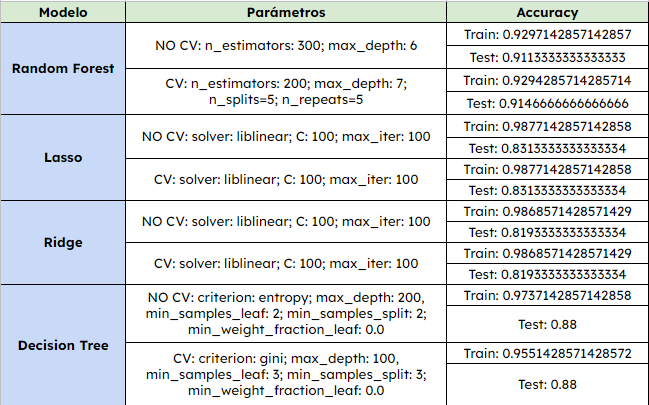

Dados estos resultados, cabría preguntarse por qué estos valores para los parámetros expuestos son los más idóneos:

*   ***Random Forest***: para este modelo, vimos que, en general, a mayor número de estimadores (es decir, número de árboles del bosque) y del parámetro *max_depth* (profundidad máxima del árbol; en general, a mayor valor más *splits* posee, capturando más información acerca de los datos, dentro de un valor razonable), mejor *performance*, por lo menos para los valores indicados a testar por la *Pipeline* correspondiente. Sin embargo, esto depende en cierta medida de los datos sobre los que esté entrenando el clasificador, y también puede que busquemos no ralentizar el proceso de aprendizaje, por lo que lo apropiado es hacer una búsqueda de parámetros apropiados, tal y como hemos hecho en esta práctica.
*   ***Lasso/Ridge***: para estos dos modelos de regresión logística con regularización, encontramos dos parámetros principales que hemos calibrado en esta práctica (si bien existen otros parámetros que aquí se han mantenido en sus valores por defecto): *C* y *max_iter*. Por su parte, *C* es un parámetro que, a menor valor, indica mayor fuerza de regularización (que es una técnica empleada para tratar de evitar el *overfitting*). Por tanto, los resultados parecen indicar que, para el rango de valores de *C* testado en las *Pipelines*, el más pequeño es el más apropiado, es decir, el referente a una mayor regularización, dando a entender que el *training data* no es muy representativo de los datos reales. Por otro lado, respecto a *max_iter*, éste parámetro se refiere al número de iteraciones del *solver* (algoritmo empleado para la optimización) y buscaríamos un valor apropiado en base al *solver* empleado y el dataset, pero no parece existir una relación directa entre este parámetro y el *accuracy* del modelo. Aparte, el algoritmo *solver* depende más del tipo de regularización que estemos aplicando.
*   ***Decision Tree***: para este modelo, hemos calibrado varios parámetros. En primer lugar, encontramos *criterion*, que mide la calidad del *split*, y por lo general los criterios "gini" y "entropy" no son muy decisivos en el *performance* del modelo, ya que uno es mejor para ciertos casos y el otro para otros casos. Respecto al parámetro *max_depth*, éste se refiere a la profundidad máxima del árbol. Por lo general, éste parámetro debe encontrarse dentro de un valor intermedio, para evitar tanto el *overfitting* como el *underfitting*. Respecto al parámetro *min_samples_leaf*, éste se refiere al número mínimo de muestras requeridas para formar un nodo en el árbol, y sirve fundamentalmente para controlar el *overfitting*. Al igual que con el parámetro anterior, lo más apropiado es usar un valor intermedio. En relación a los parámetros *min_samples_split* y *min_weight_fraction_leaf*, éstos se refieren al mínimo número de muestras requeridas para dividir (del inglés, *split*) un nodo interno del árbol y a la fracción ponderada mínima de la suma total de pesos requeridos para ser un nodo del árbol, respectivamente. Al igual que con los parámetros anteriores, lo más apropiado es usar un valor intermedio.

Cabe señalar que, al diseñar las *Pipelines* que han permitido obtener el *accuracy* de estos modelos de clasificación, se ha especificado un rango de posibles valores para cada parámetro. Por tanto, para por ejemplo el modelo Lasso, se indica que el mejor valor de C es 100, pero esto es dentro del rango de posibles valores [100, 200, 500, 1000], por lo que no sabemos si habríamos obtenido mejores resultados para el modelo escogiendo un valor de C inferior a 100 o superior a 1000.

### **1.7.4: PCA y modelos de clustering**

Si recordamos, hemos realizado 5 experimentos para la generación de distintos modelos de clustering usando el método *K-means*, modificando en cada caso el número de componentes del PCA realizado anteriormente con el fin de reducir la dimensionalidad de los datos y mejorar la precisión de los modelos. 

A continuación, se muestra una tabla resumiendo los resultados obtenidos para cada modelo de clustering, indicando el número de clusters, el número de componentes del PCA que ha permitido la obtención de los mismos y el índice de Calinski-Harabasz del modelo:

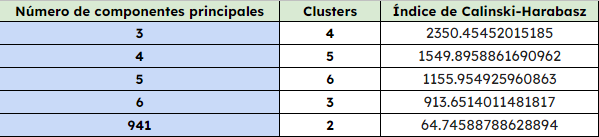

## **1.8: Referencias**

1. https://365datascience.com/tutorials/python-tutorials/pca-k-means/
2. https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
3. https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-8-dimensionality-reduction-chi2-pca-c6d06fb3fcf3
4. https://stats.stackexchange.com/questions/476652/first-two-principal-components-explain-100-variance-of-tfidf-weighted-tweet-vec
5. https://stats.stackexchange.com/questions/68289/clustering-of-documents-that-are-very-different-in-number-of-words
6. https://stackoverflow.com/questions/43784903/scikit-k-means-clustering-performance-measure
7. https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c
8. https://es.acervolima.com/indice-de-calinski-harabasz-indices-de-validez-de-conglomerados-conjunto-3/#:~:text=El%20%C3%ADndice%20de%20Calinski%2DHarabasz(CH)(introducido%20por%20Calinski,caracter%C3%ADsticas%20inherentes%20a%20la%20conjunto
9. https://builtin.com/data-science/step-step-explanation-principal-component-analysis
10. https://andrewmourcos.github.io/blog/2019/06/06/PCA.html
11. https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features#:~:text=Tf%2DIdf%20is%20meant%20to,data%20is%20just%20too%20small.
12. https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/#:~:text=Elbow%20Method,-In%20the%20Elbow&text=WCSS%20is%20the%20sum%20of,is%20largest%20when%20K%20%3D%201.
13. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
14. https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
15. https://charleshsliao.wordpress.com/2017/05/20/logistic-regression-in-python-to-tune-parameter-c/
16. https://www.edureka.co/community/164582/what-is-c-parameter-in-sklearn-logistic-regression#:~:text=C%20is%20known%20as%20a,training%20data%20leads%20to%20overfitting.
17. https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regression
18. https://www.edureka.co/blog/regularization-in-machine-learning/
19. https://www.einfochips.com/blog/regularization-make-your-machine-learning-algorithms-learn-not-memorize/
20. https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
